In [1]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import math
import argparse
import imutils
import pickle
import cv2
import os
import copy
from imutils import paths

Using TensorFlow backend.


In [2]:
imagepath = "examples/G_counter1.jpg"
image = cv2.imread(imagepath)
output=image.copy()

image = cv2.resize(image, (160, 160))
L1 = cv2.Canny(image,50,280,L2gradient=False)
image = L1.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)


print("[INFO] loading network...")
model = load_model("pokedex.model")
lb = pickle.loads(open("lb.pickle", "rb").read())

[INFO] loading network...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [3]:
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

output = imutils.resize(output, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)

# show the output image
print("[INFO] {}".format(label))
cv2.imshow("Output", output)
cv2.waitKey(0)


[INFO] classifying image...
[INFO] G


-1

In [4]:

def get_kernels_output(model,layer_index,model_input,training_flag=False):
    get_outputs = K.function([model.layers[0].input,K.learning_phase()],[model.layers[layer_index].output])
    kernels_output = get_outputs([model_input,training_flag])[0]
    return kernels_output
#kernels_output = get_kernels_output(model,0,image,False)

In [5]:
def combine_output_images(kernels_output):
    output_count = kernels_output.shape[1]
    width = int(math.sqrt(output_count))
    height = int(math.ceil(float(output_count)/width))
    if len(kernels_output.shape)==4:
        output_shape = kernels_output.shape[2: ]
        image = np.zeros((height*output_shape[0],width*output_shape[1]),dtype = kernels_output.dtype)
        for index, output in enumerate(kernels_output[0]):
            i = int(index/width)
            j = index%width
            image[i*output_shape[0]:(i+1)*output_shape[0],j*output_shape[1]:(j+1)*output_shape[1]] = output
        return image
#combine_output_images(kernels_output)    

conv2d_1


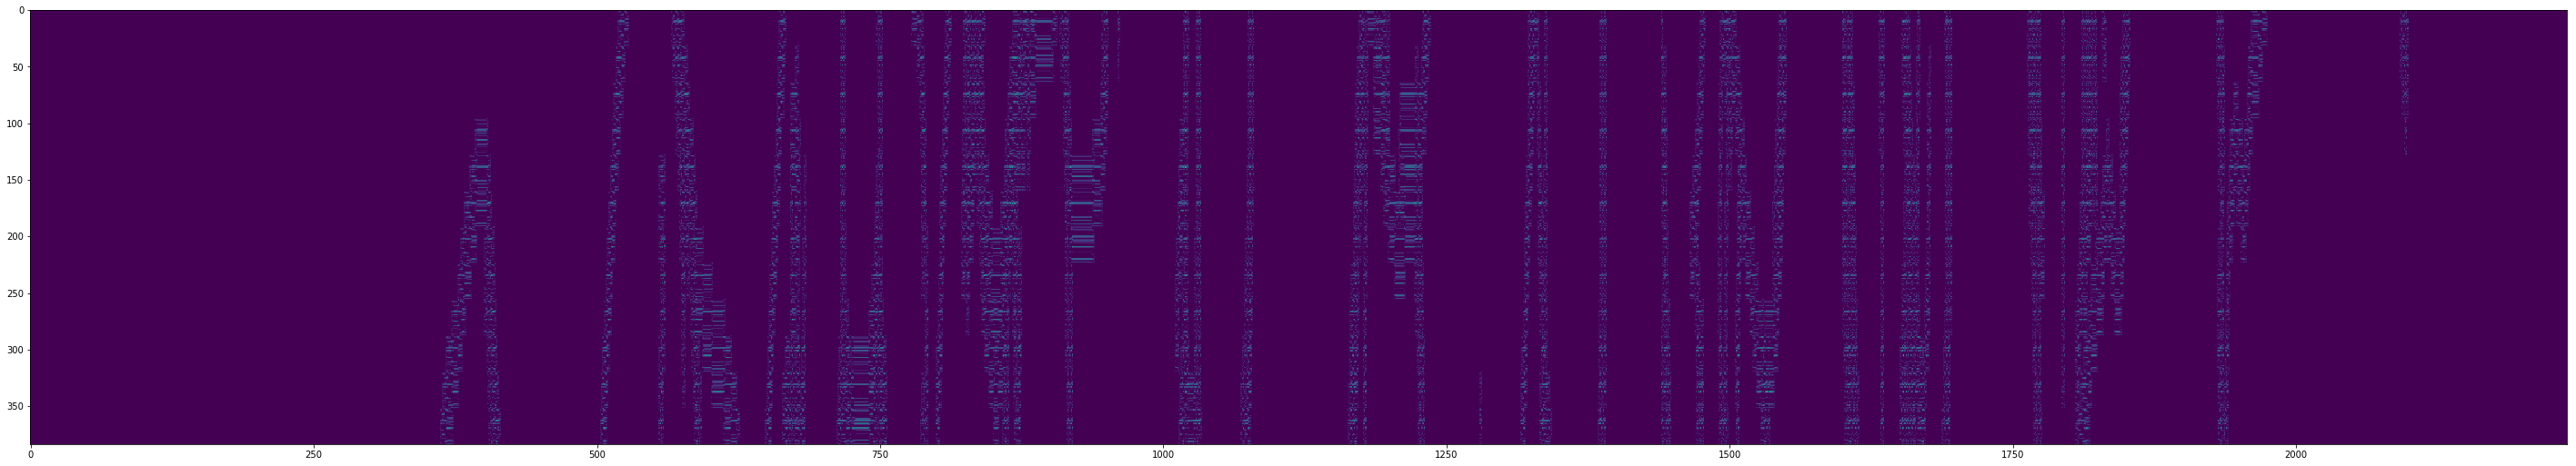

activation_1


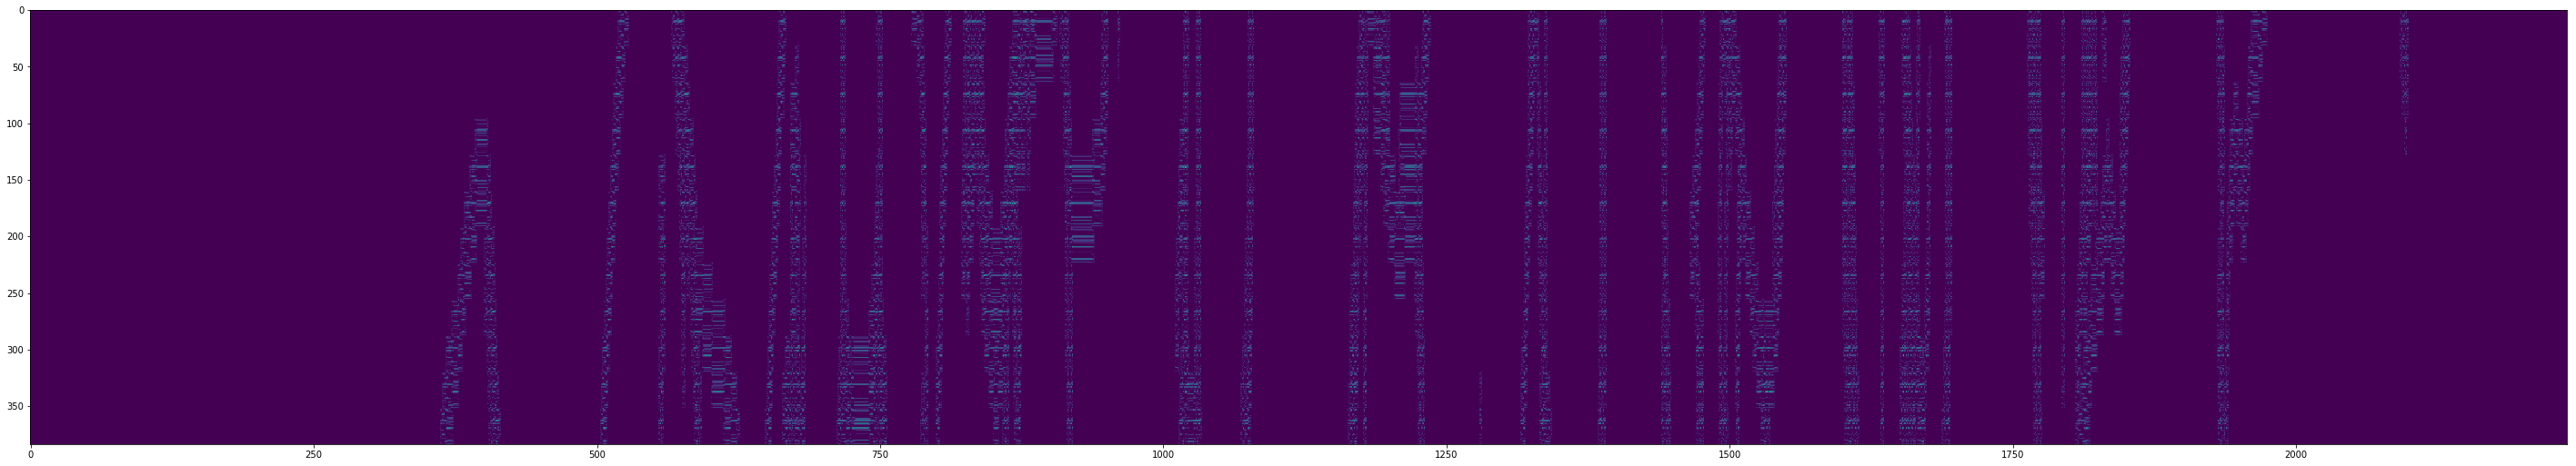

batch_normalization_1


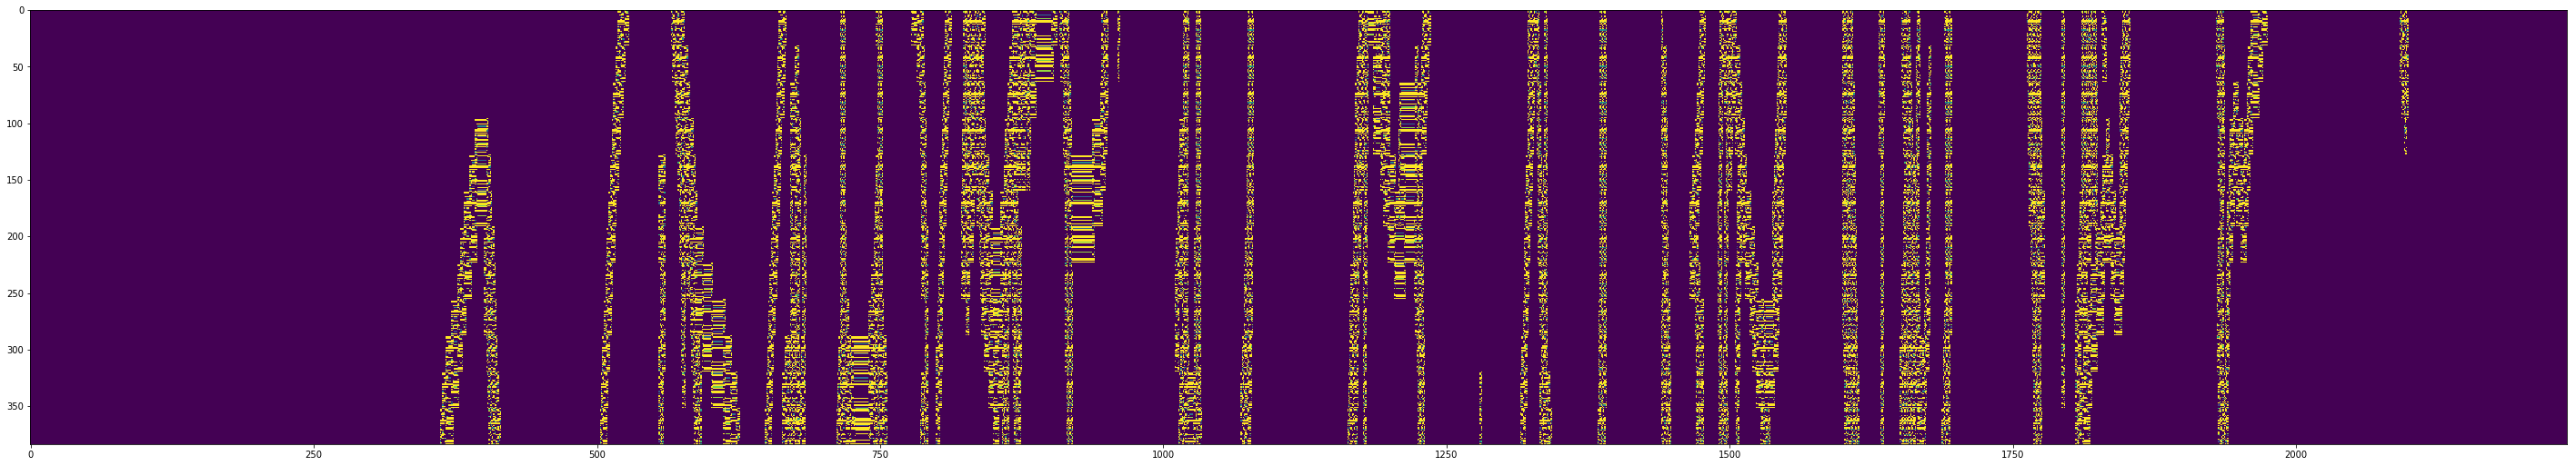

max_pooling2d_1


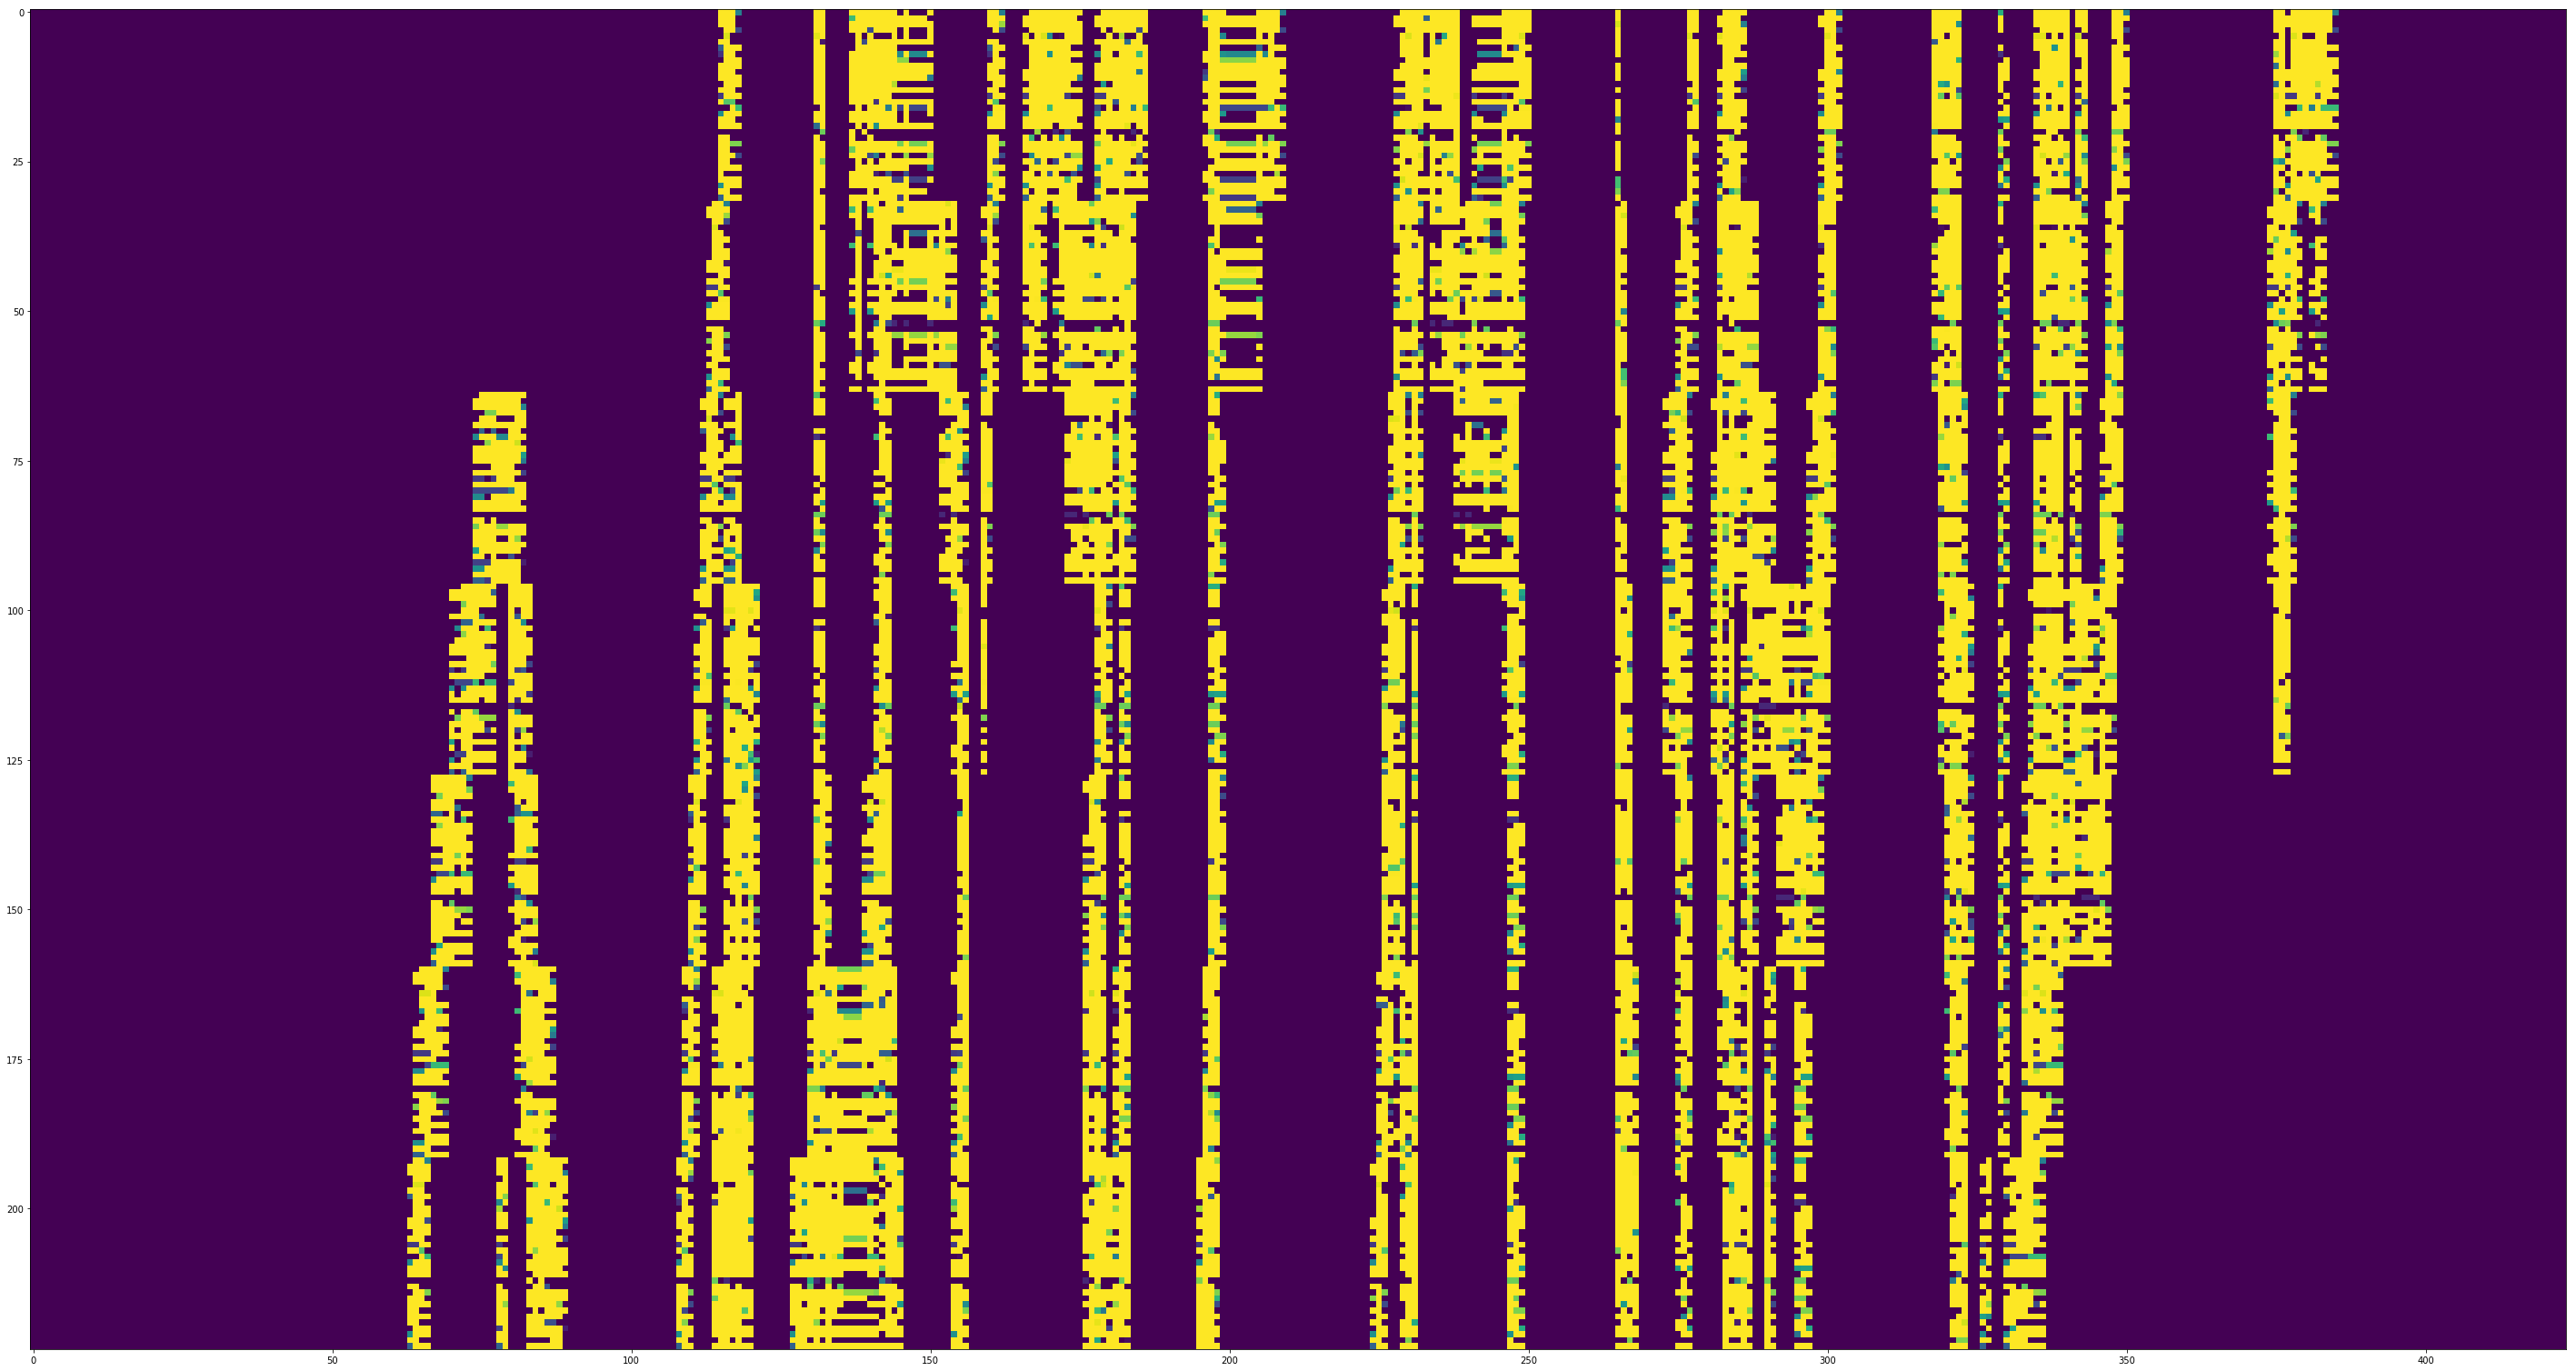

dropout_1


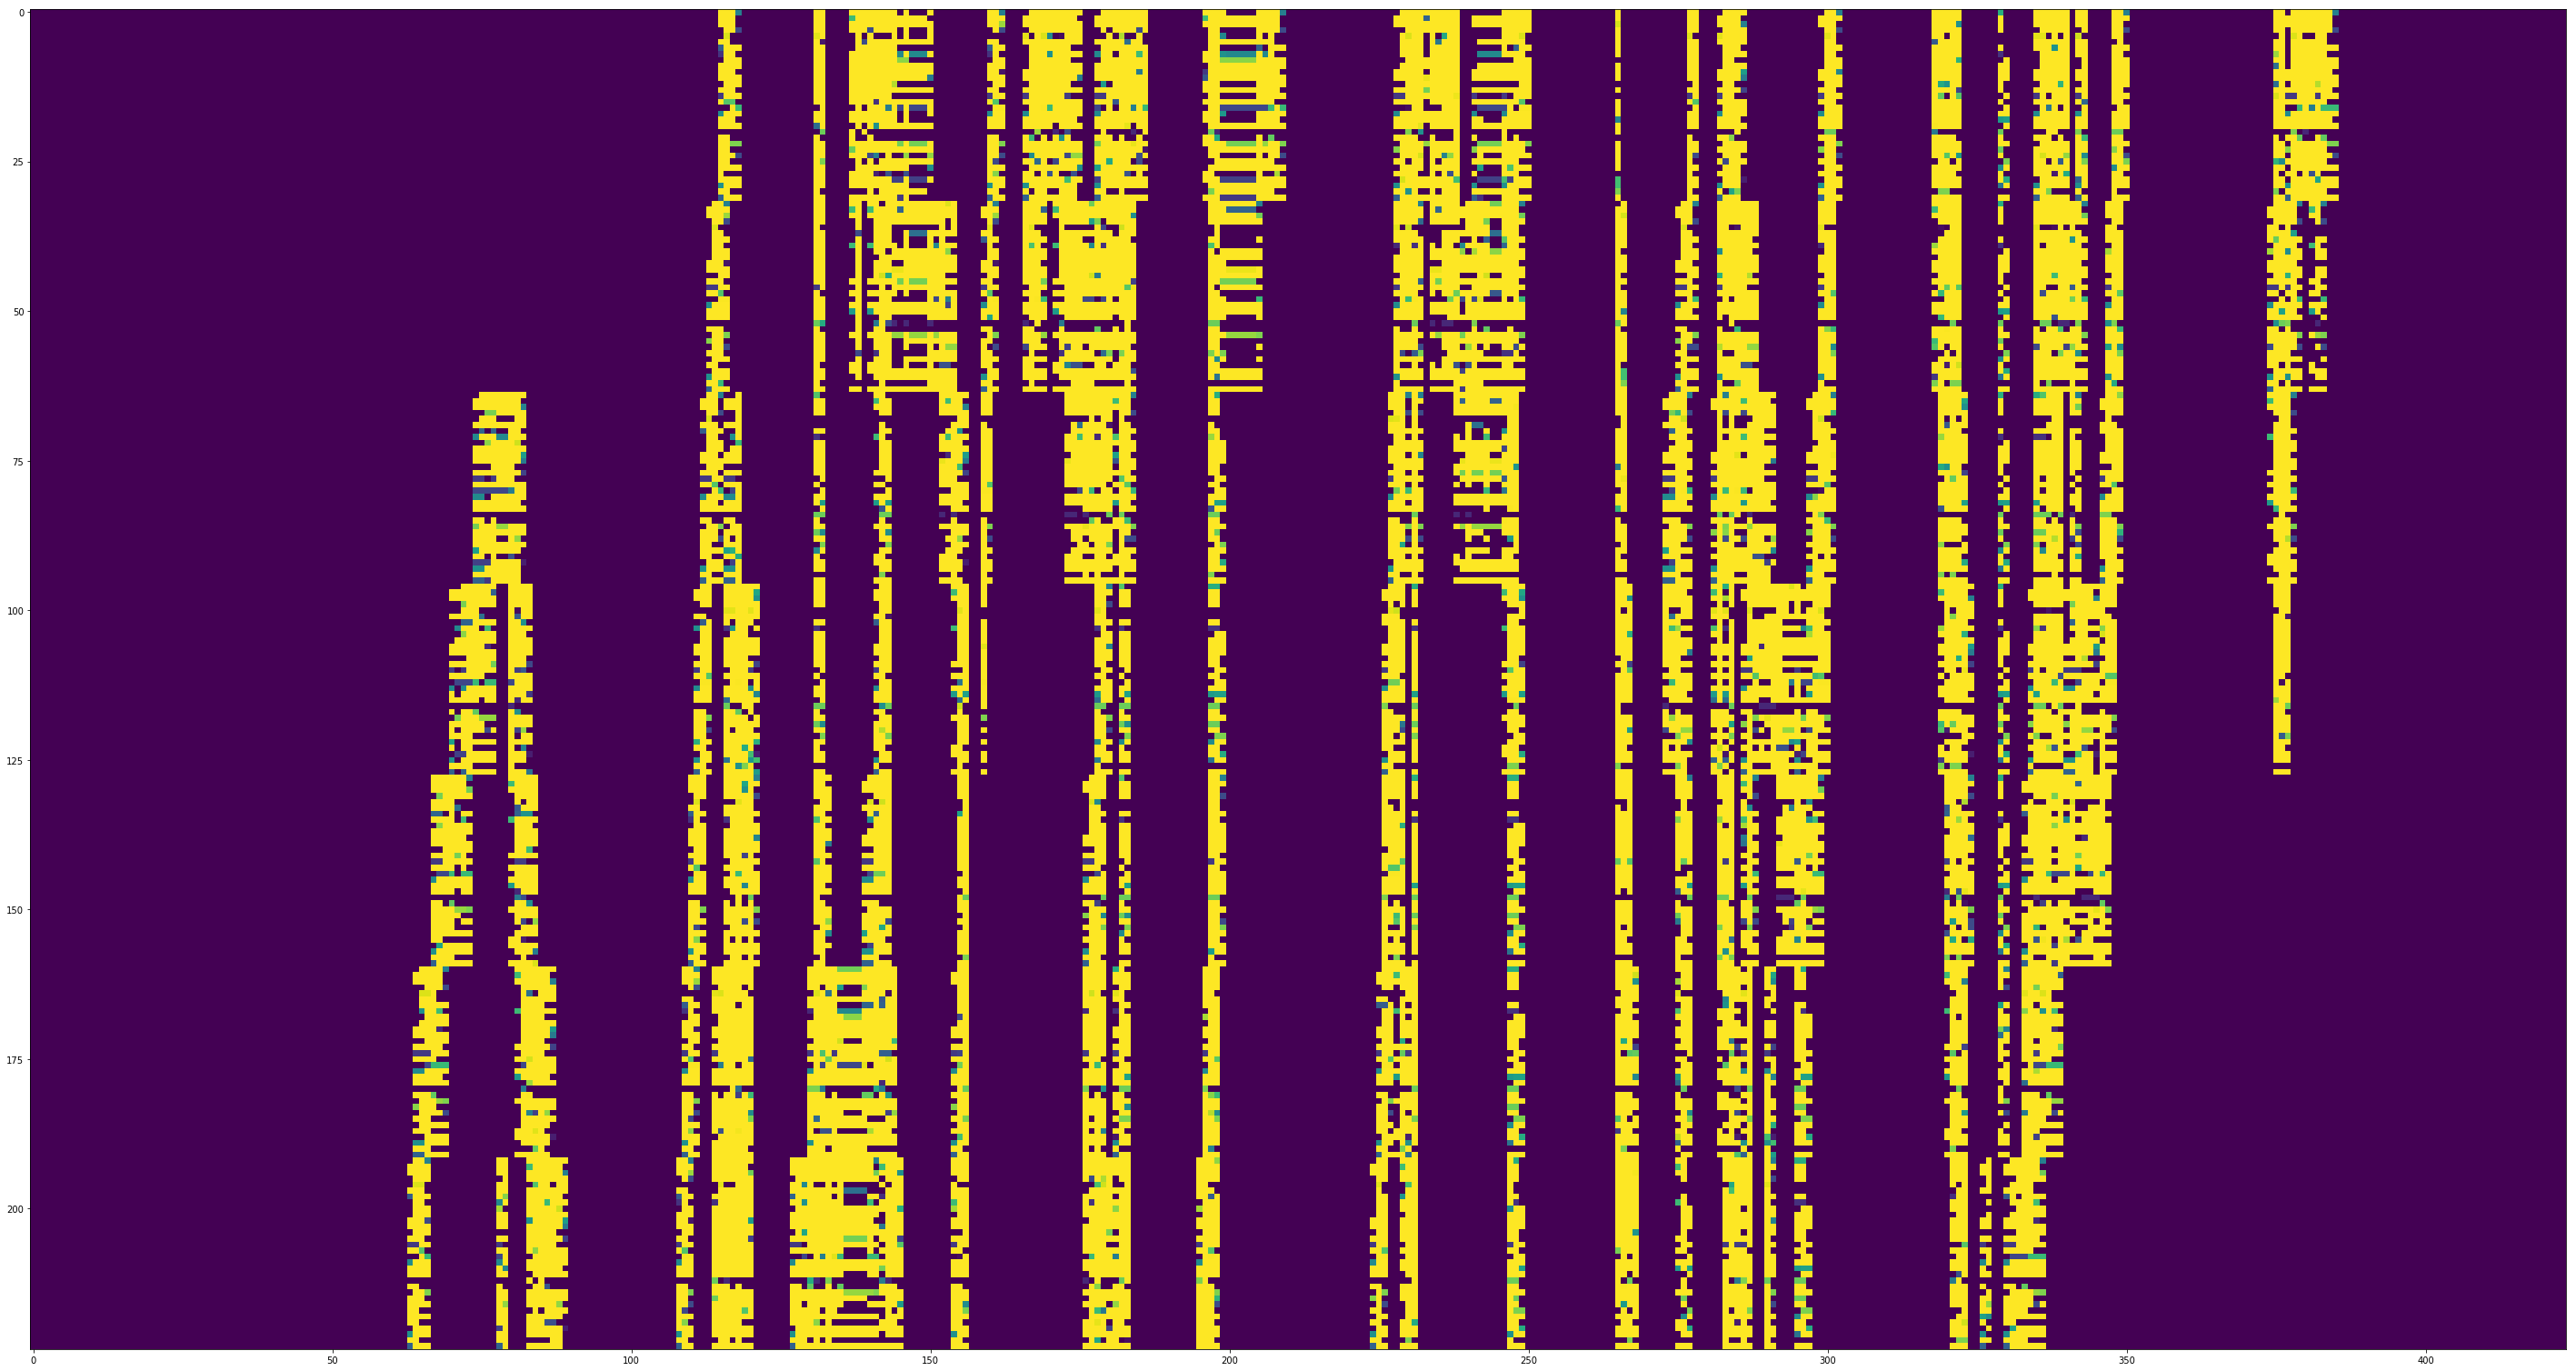

conv2d_2


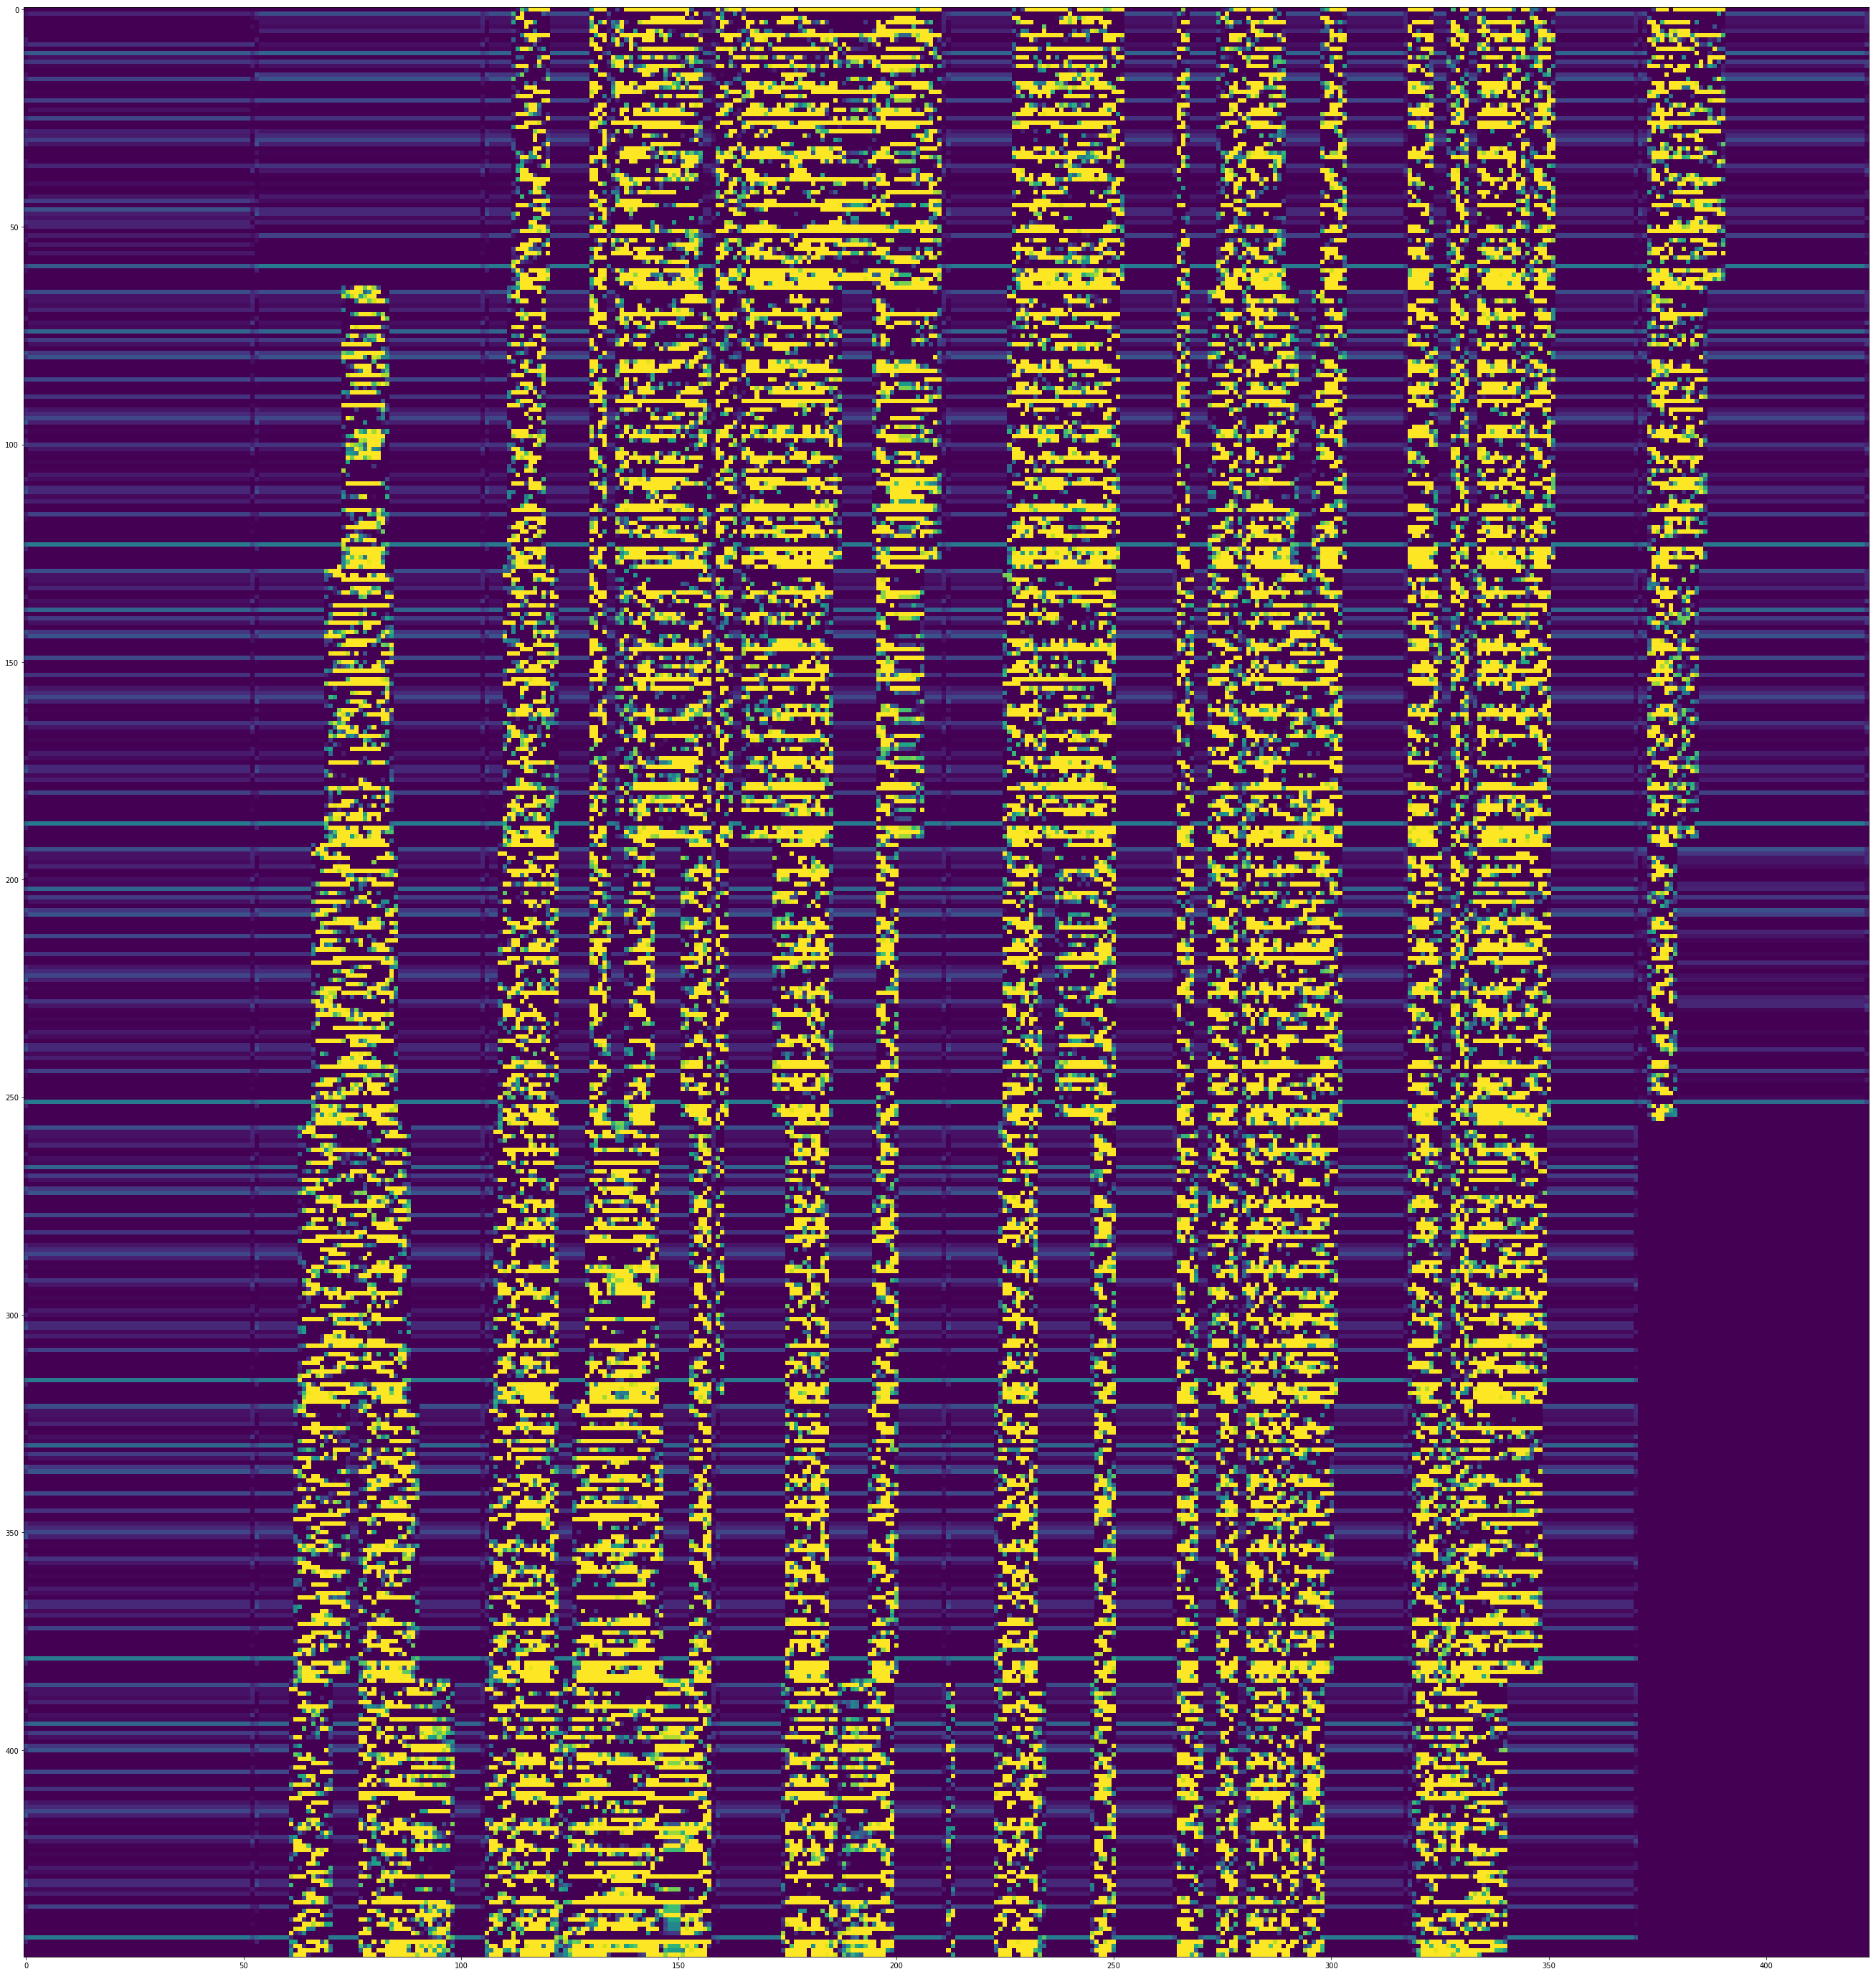

activation_2


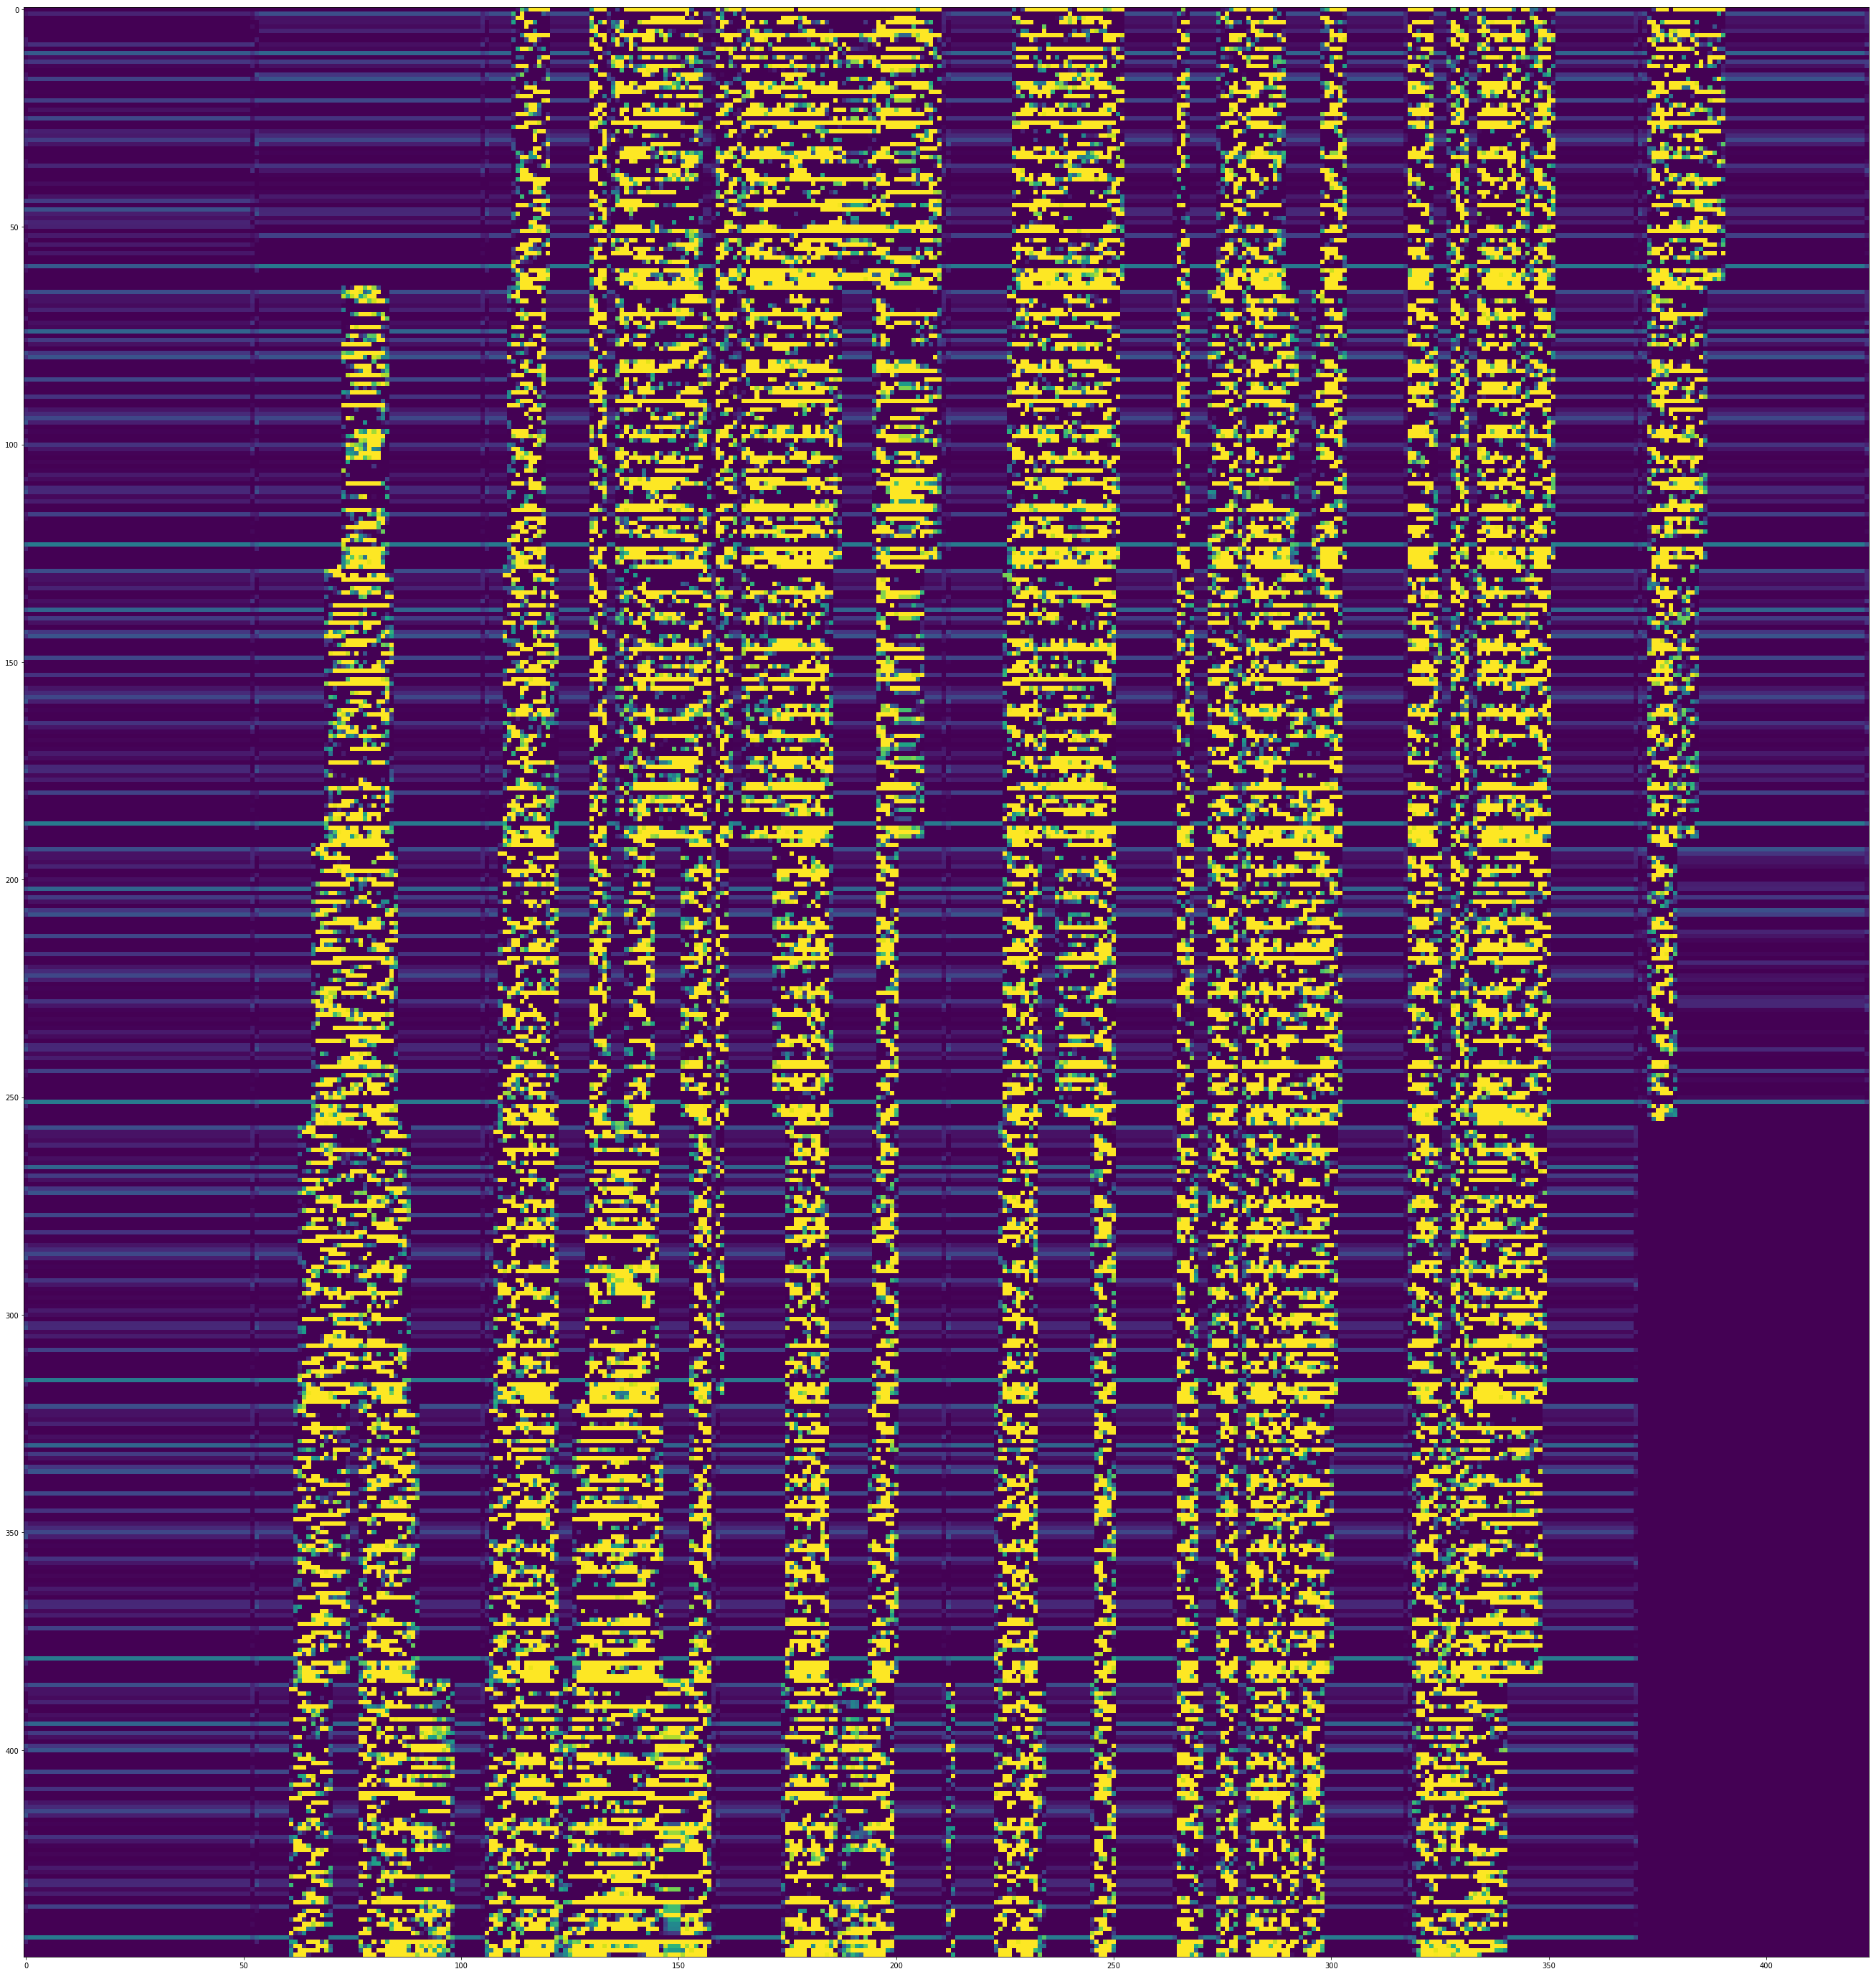

batch_normalization_2


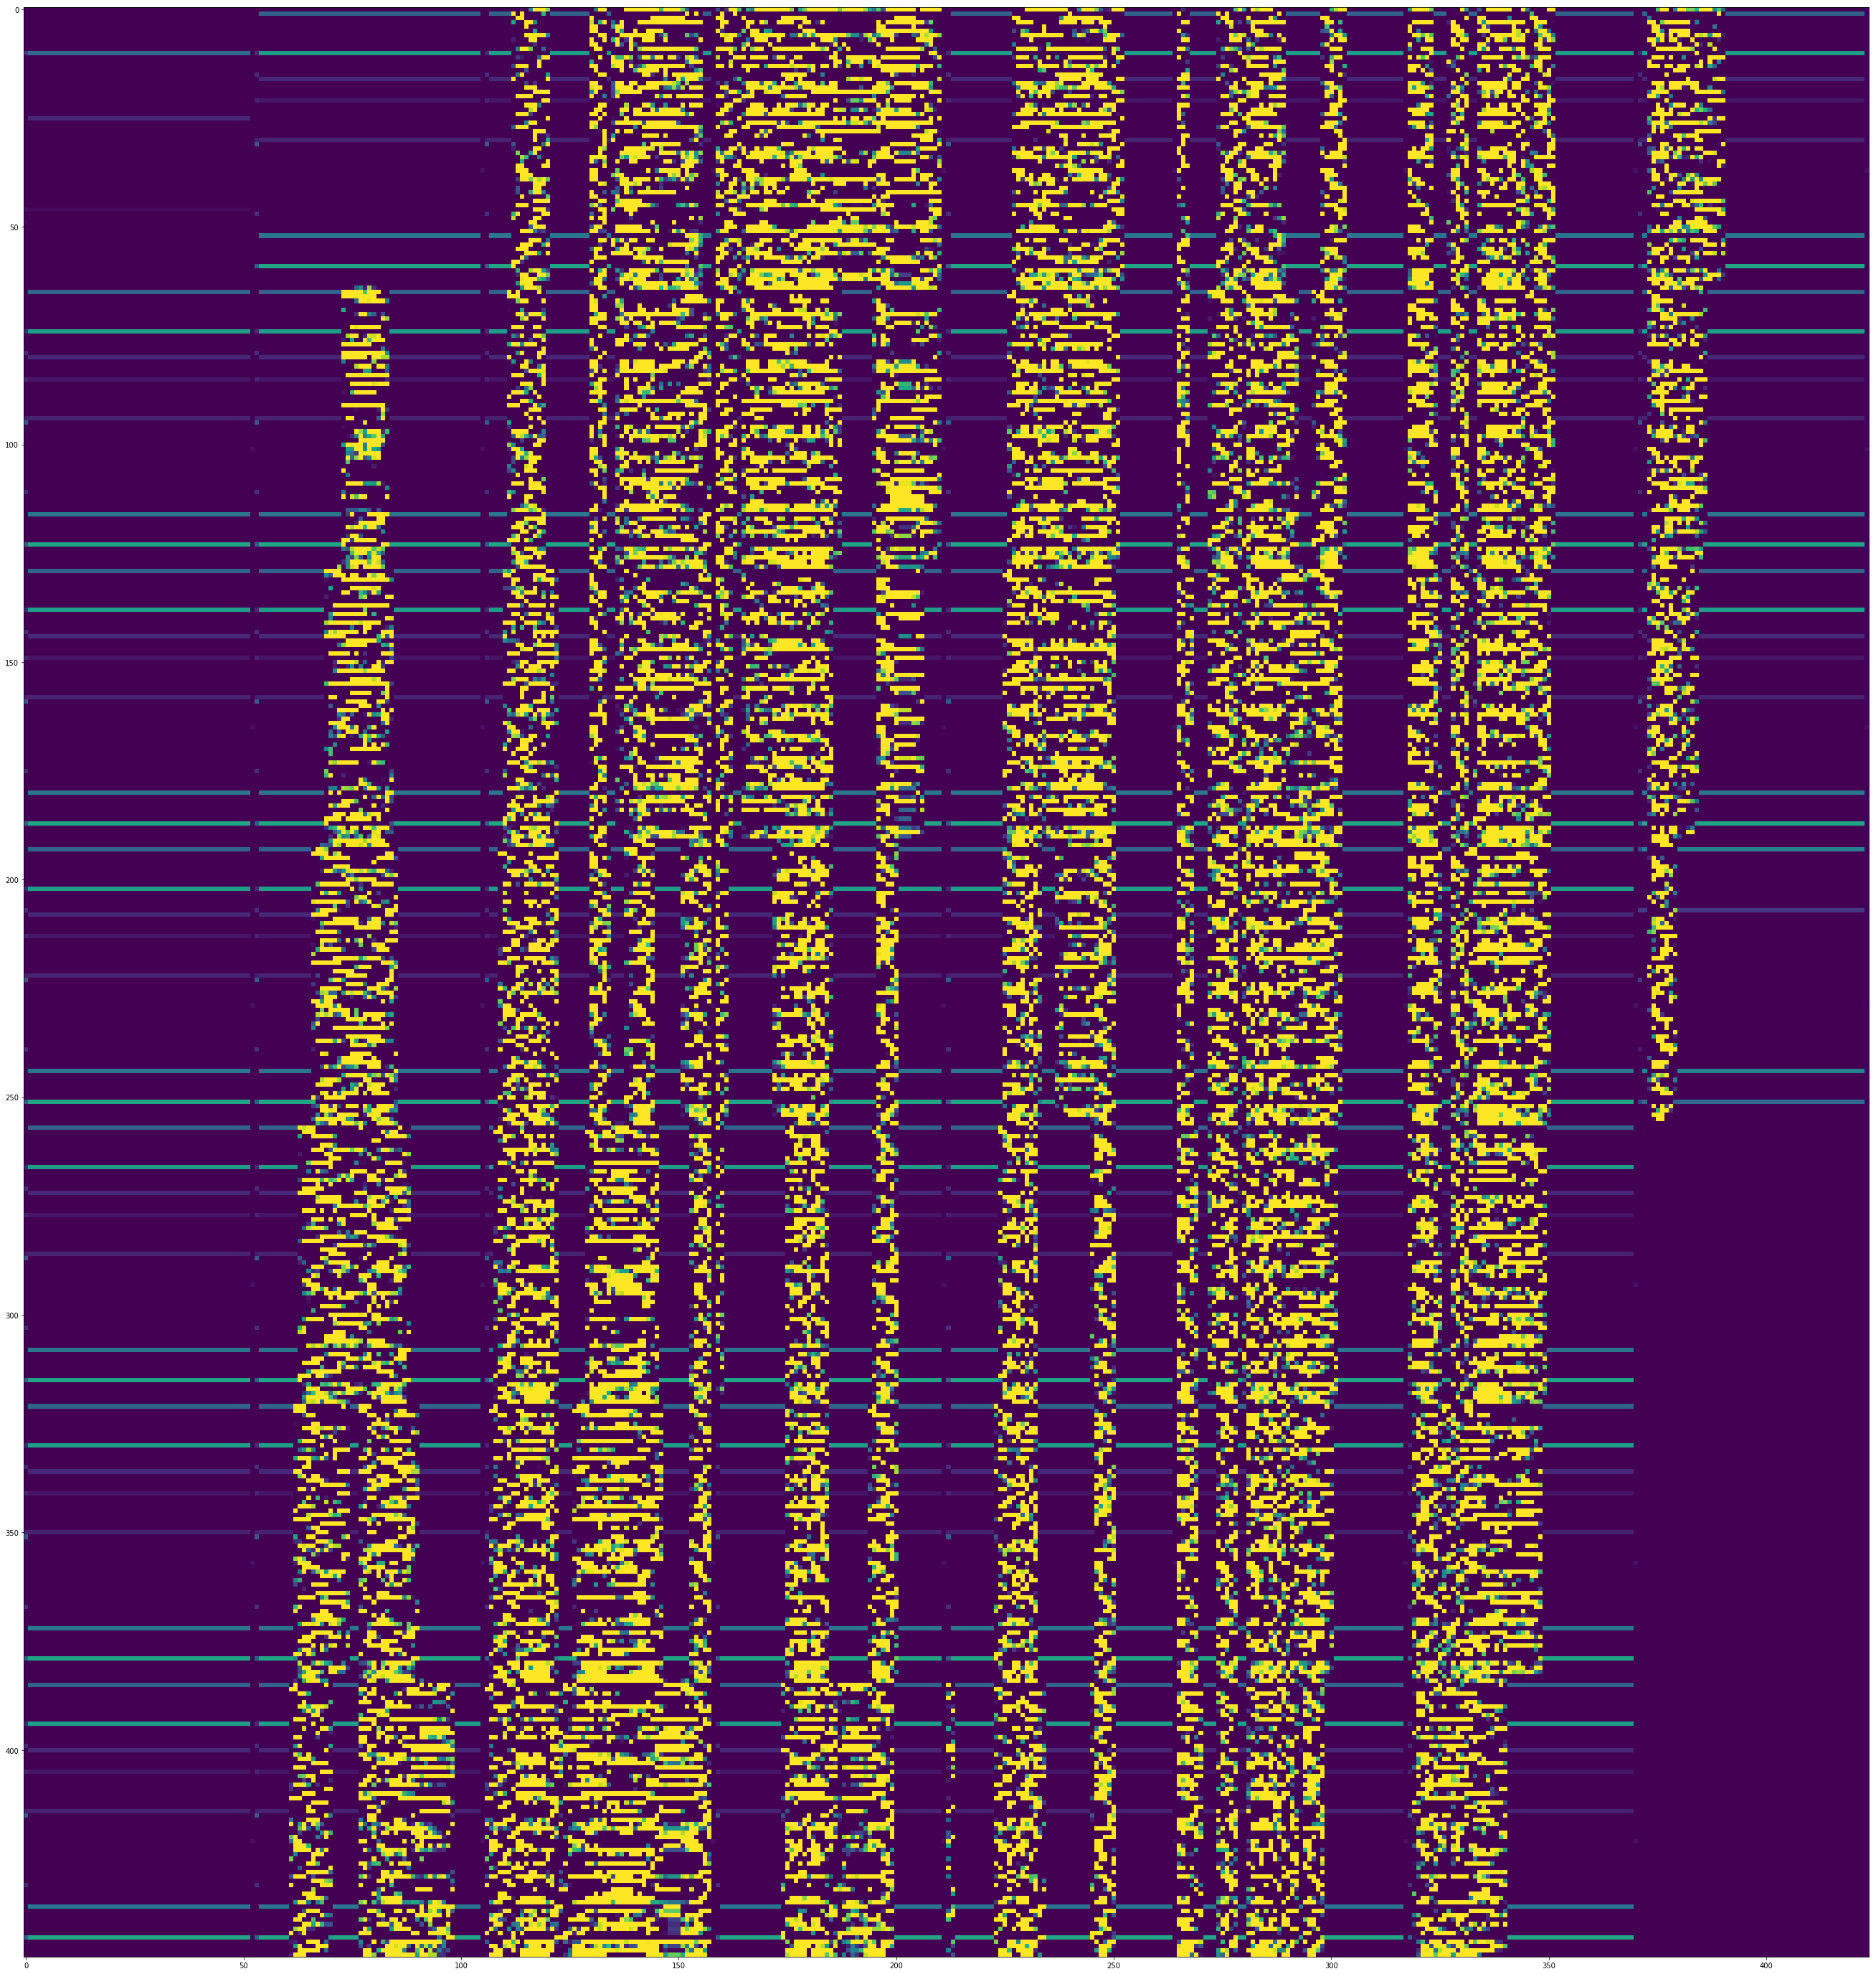

conv2d_3


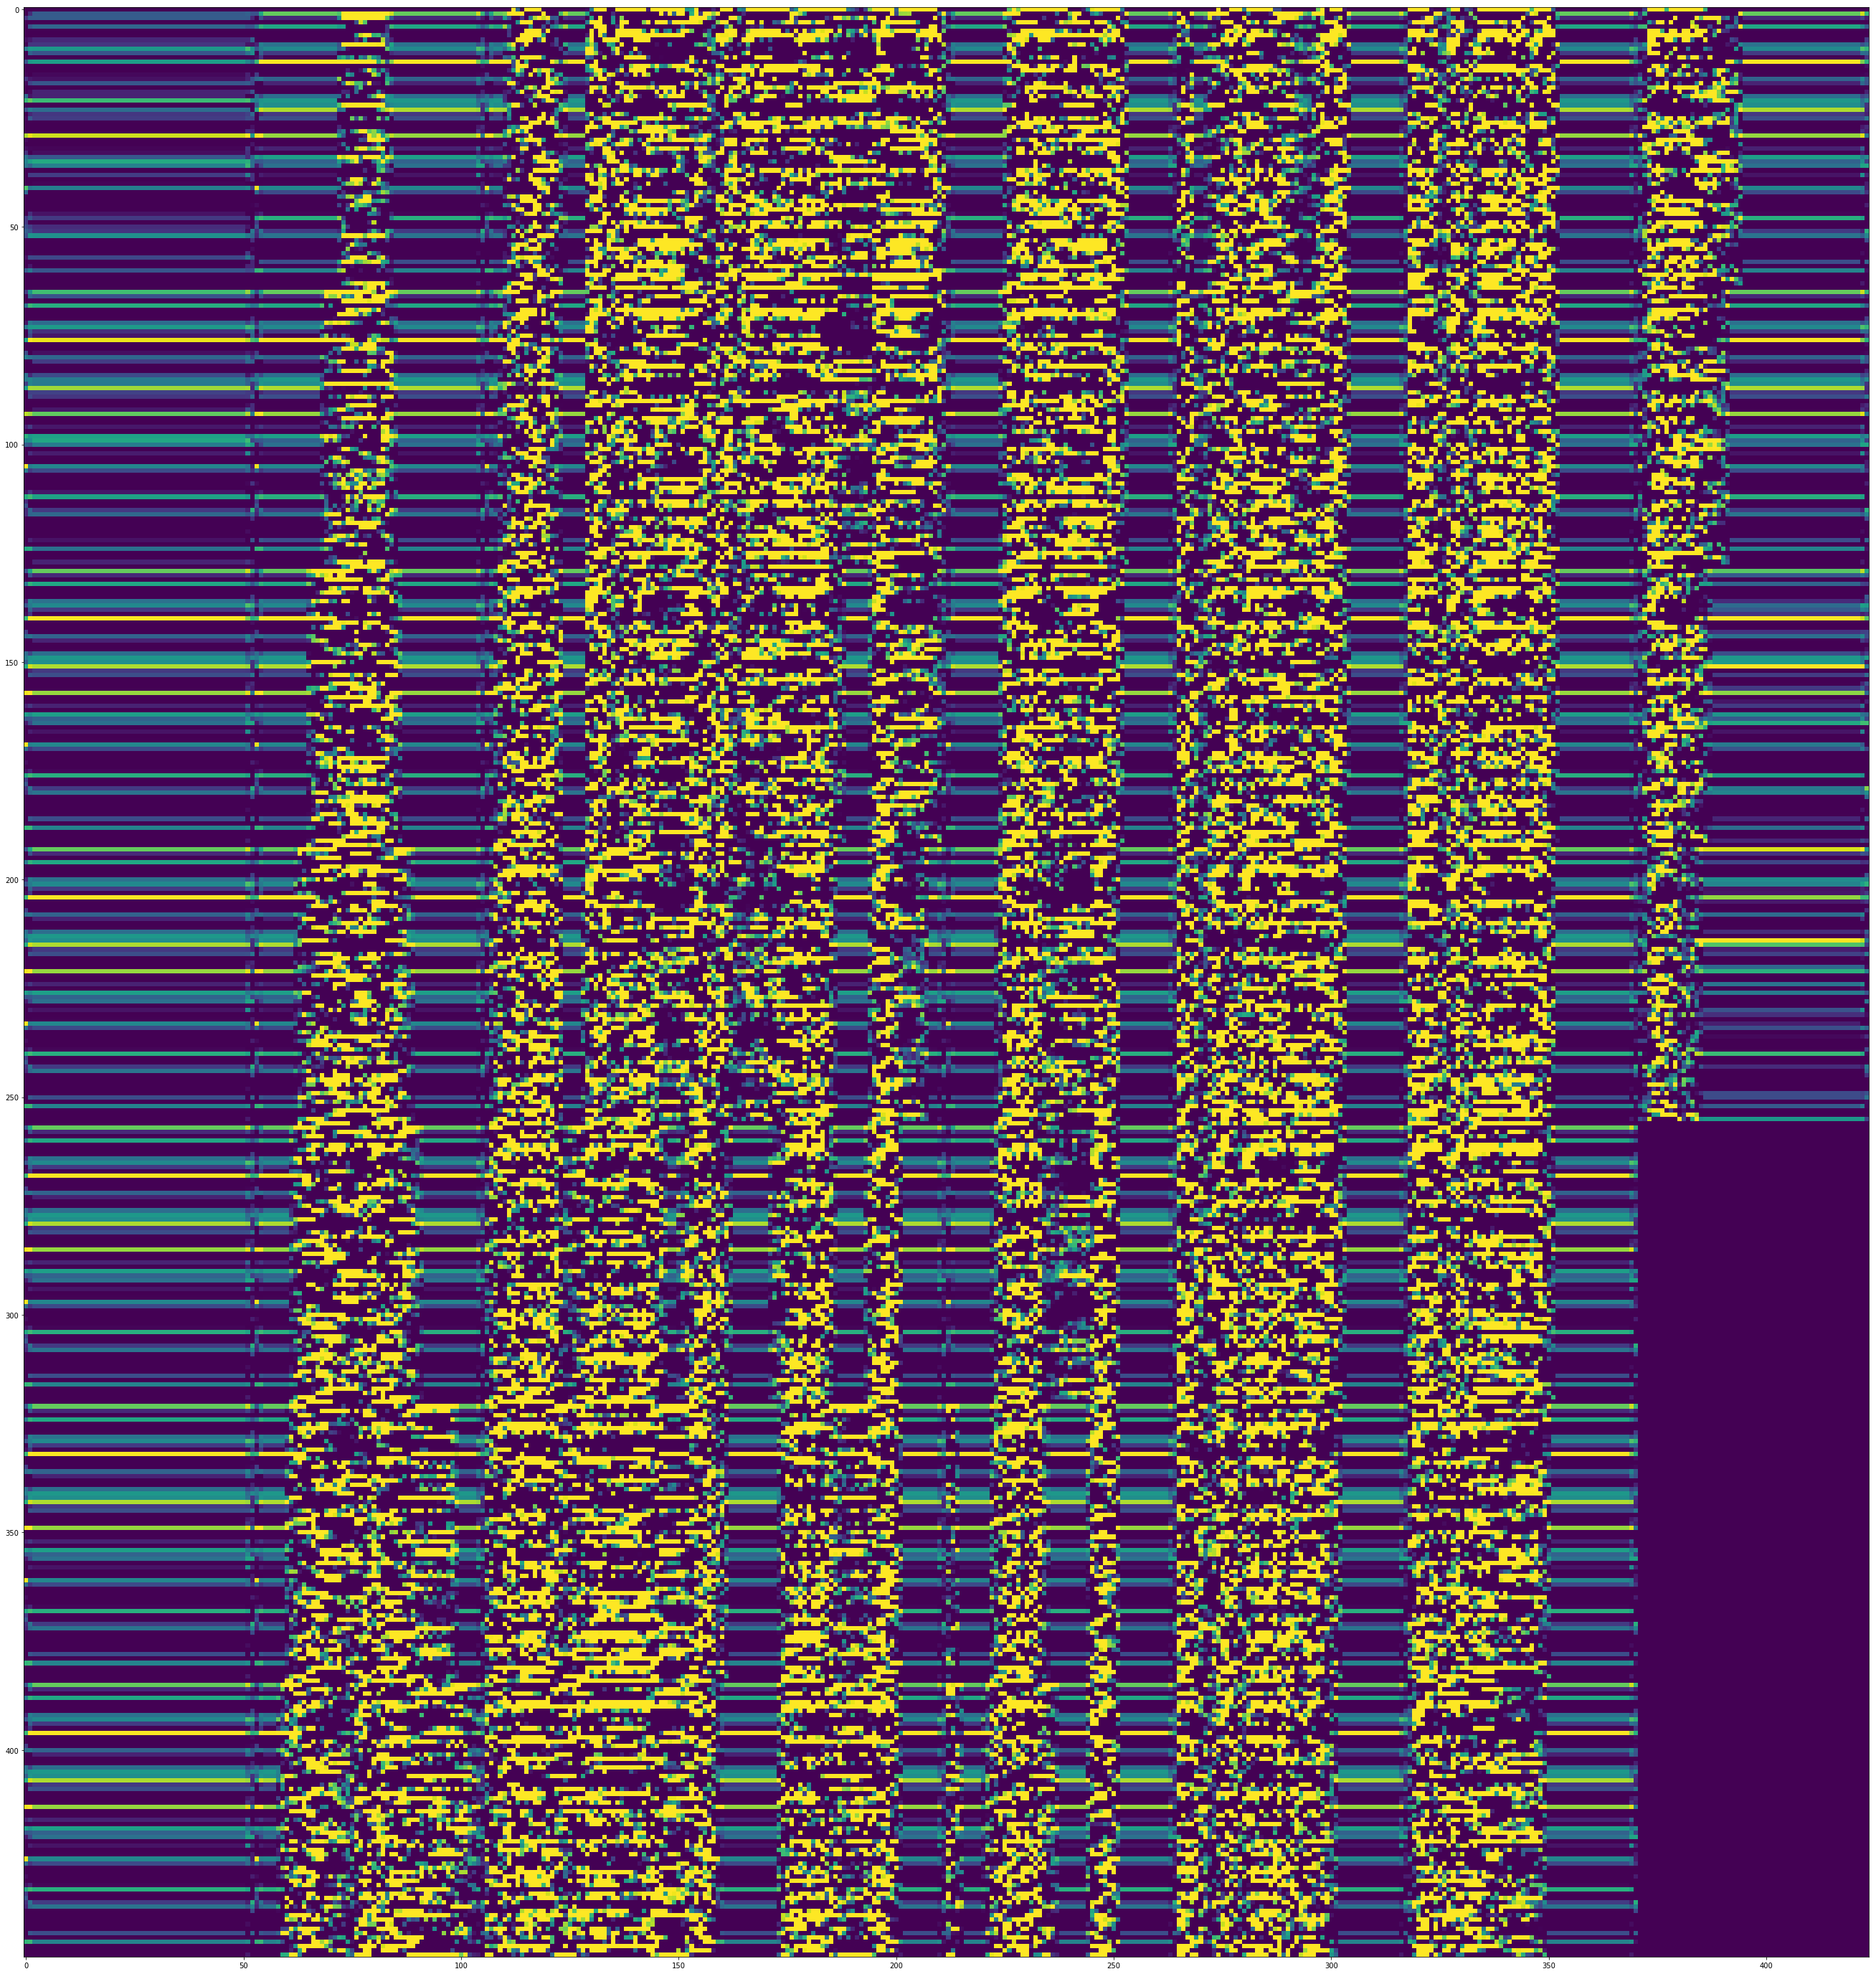

activation_3


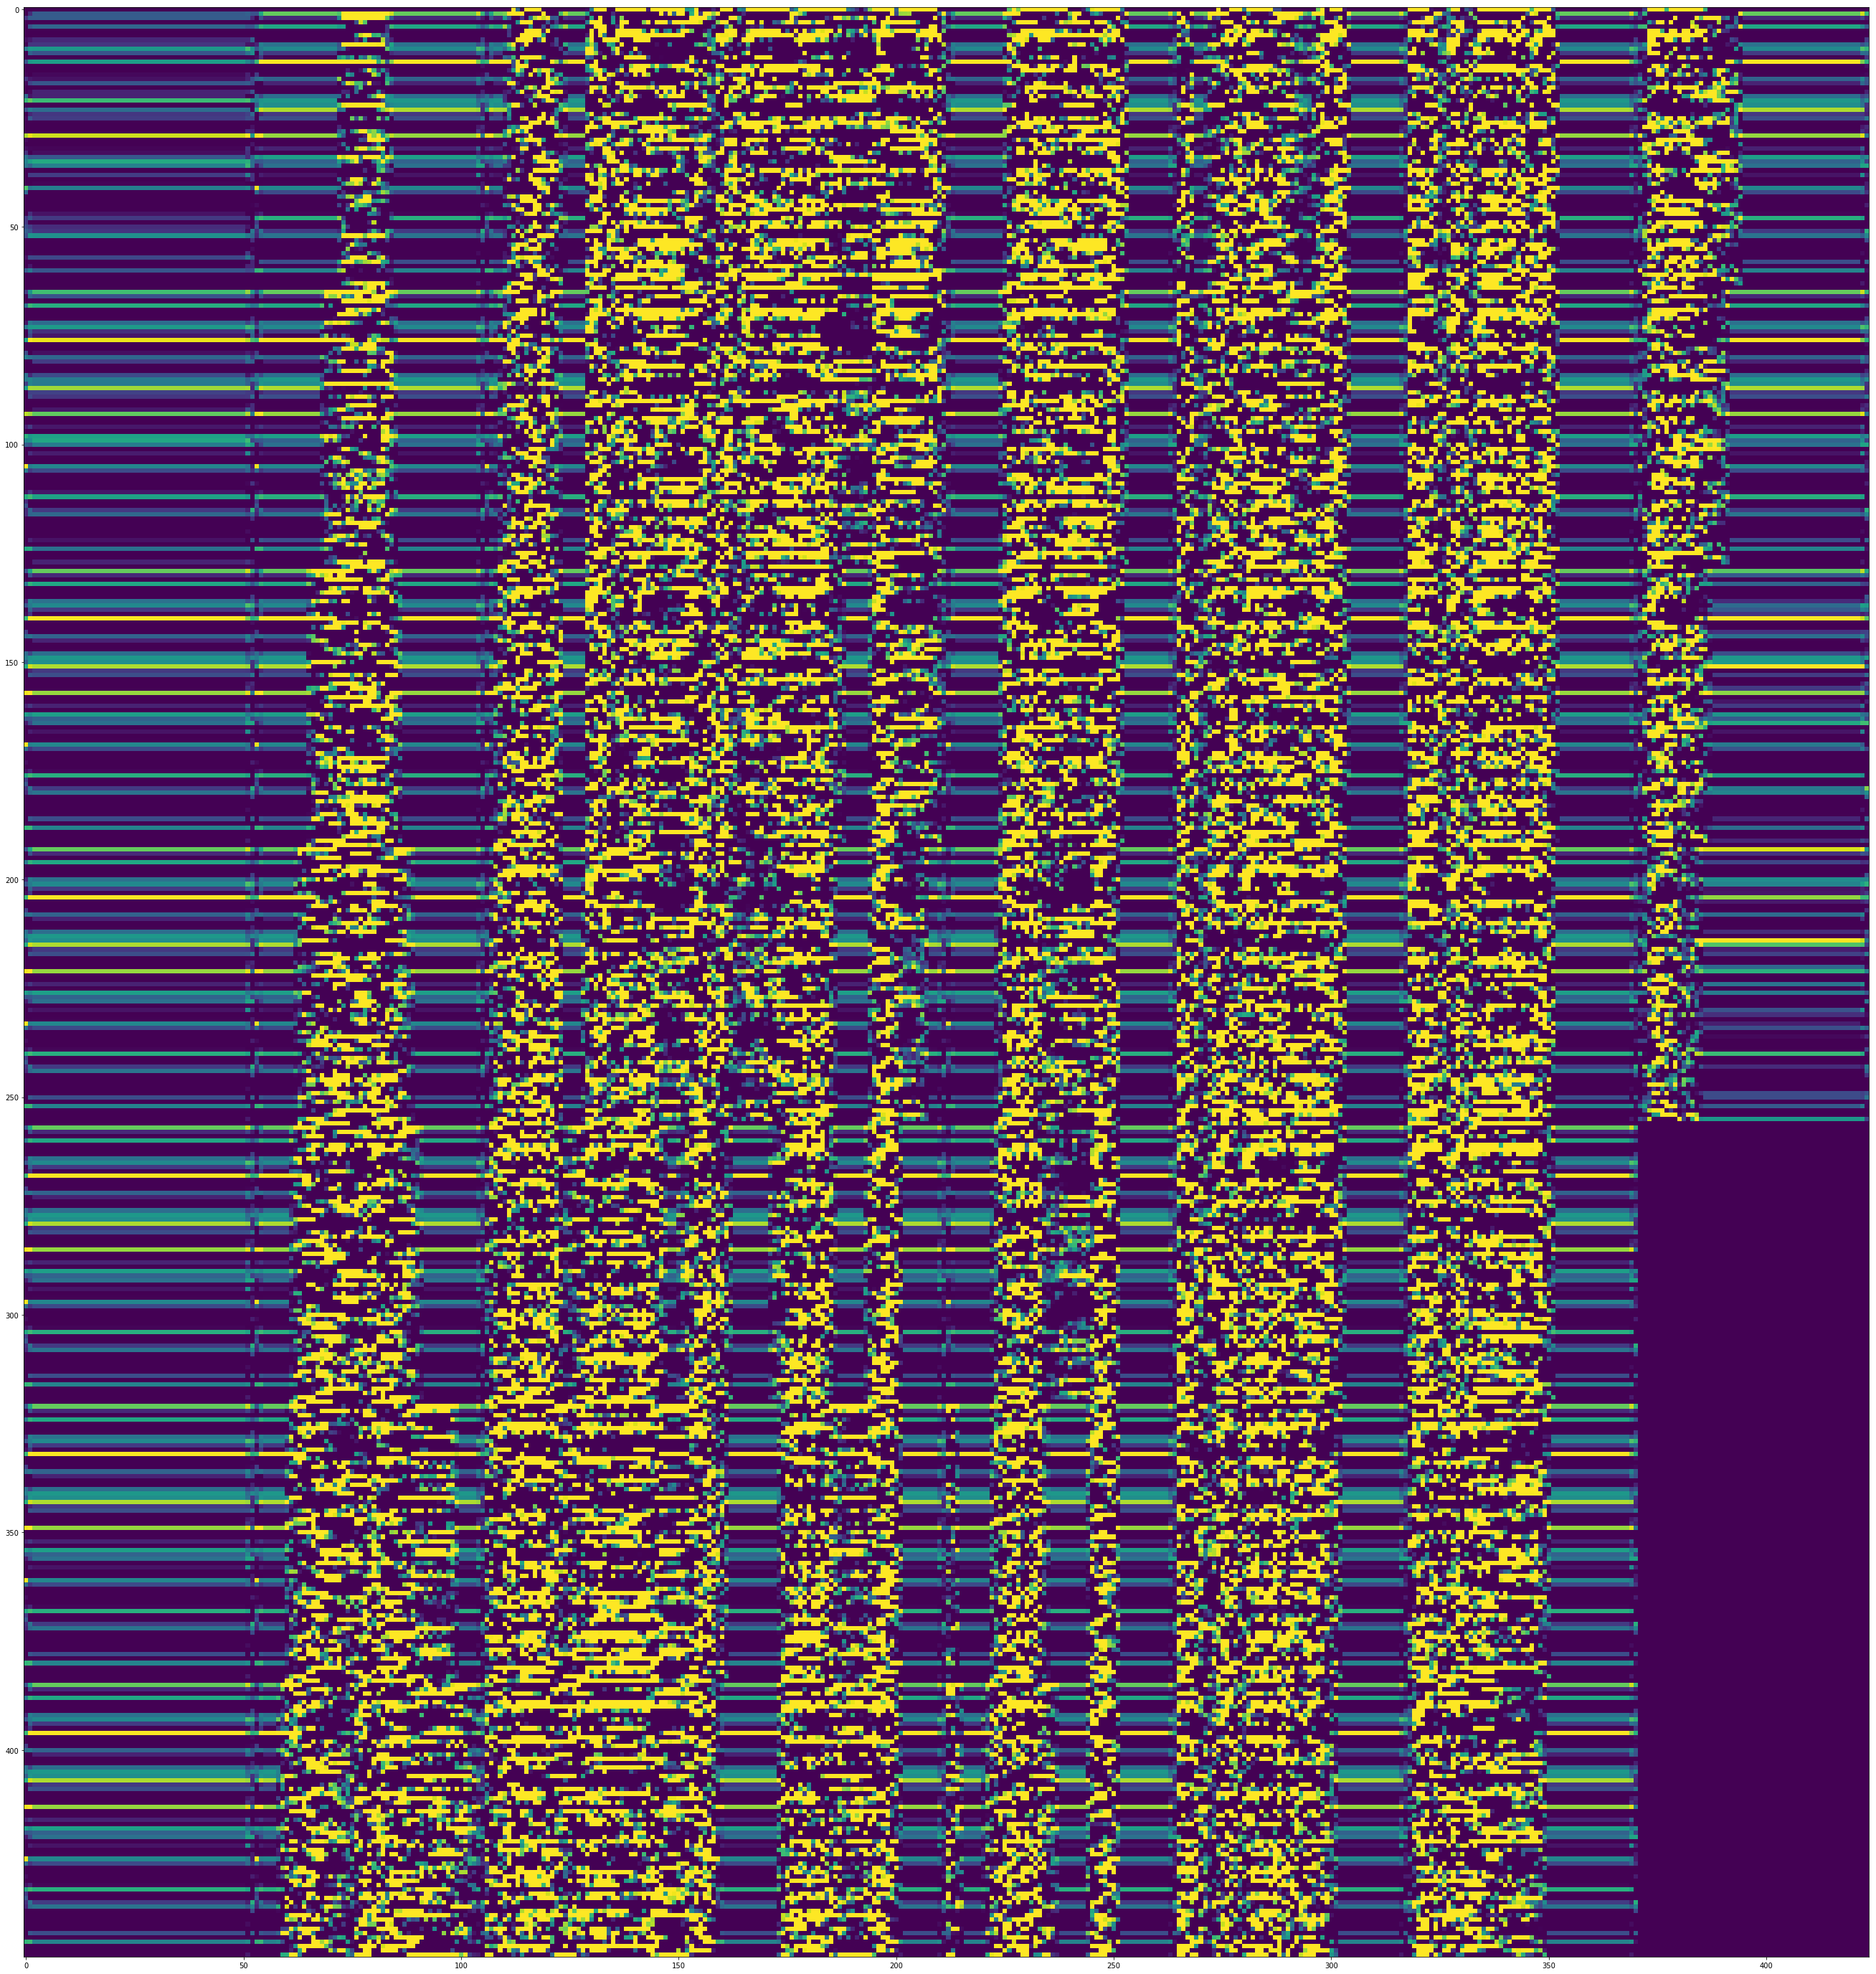

batch_normalization_3


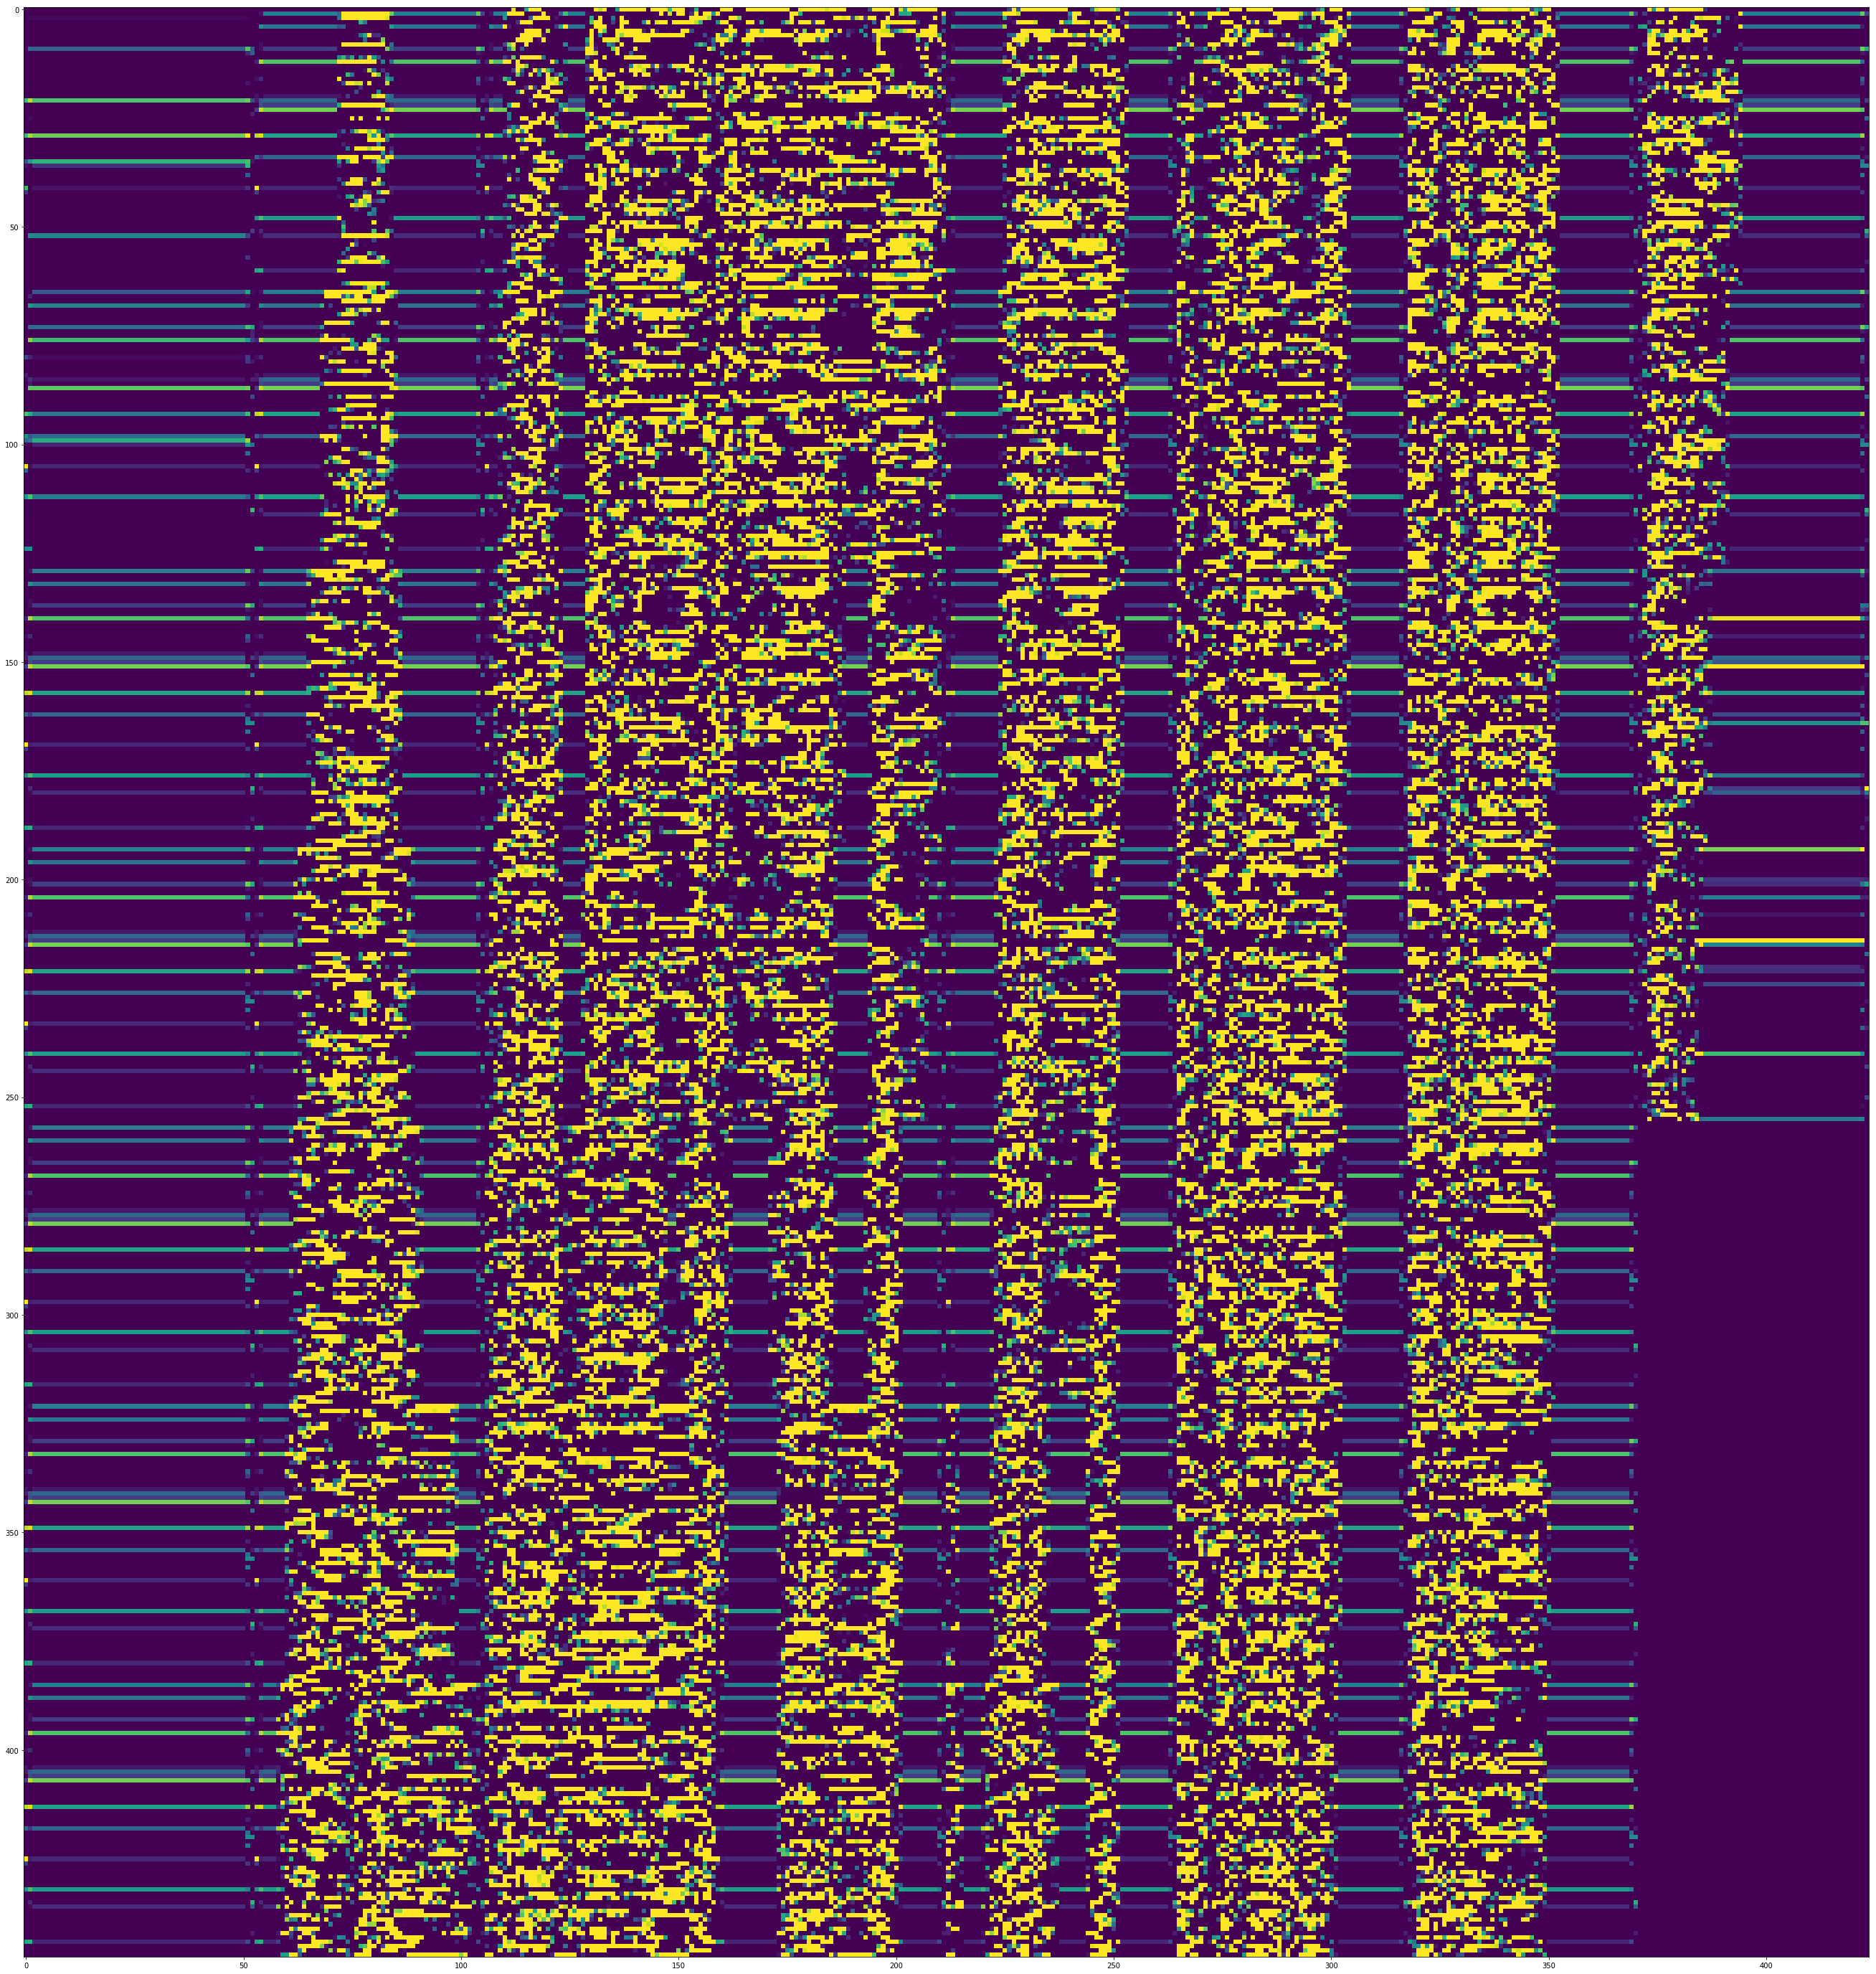

max_pooling2d_2


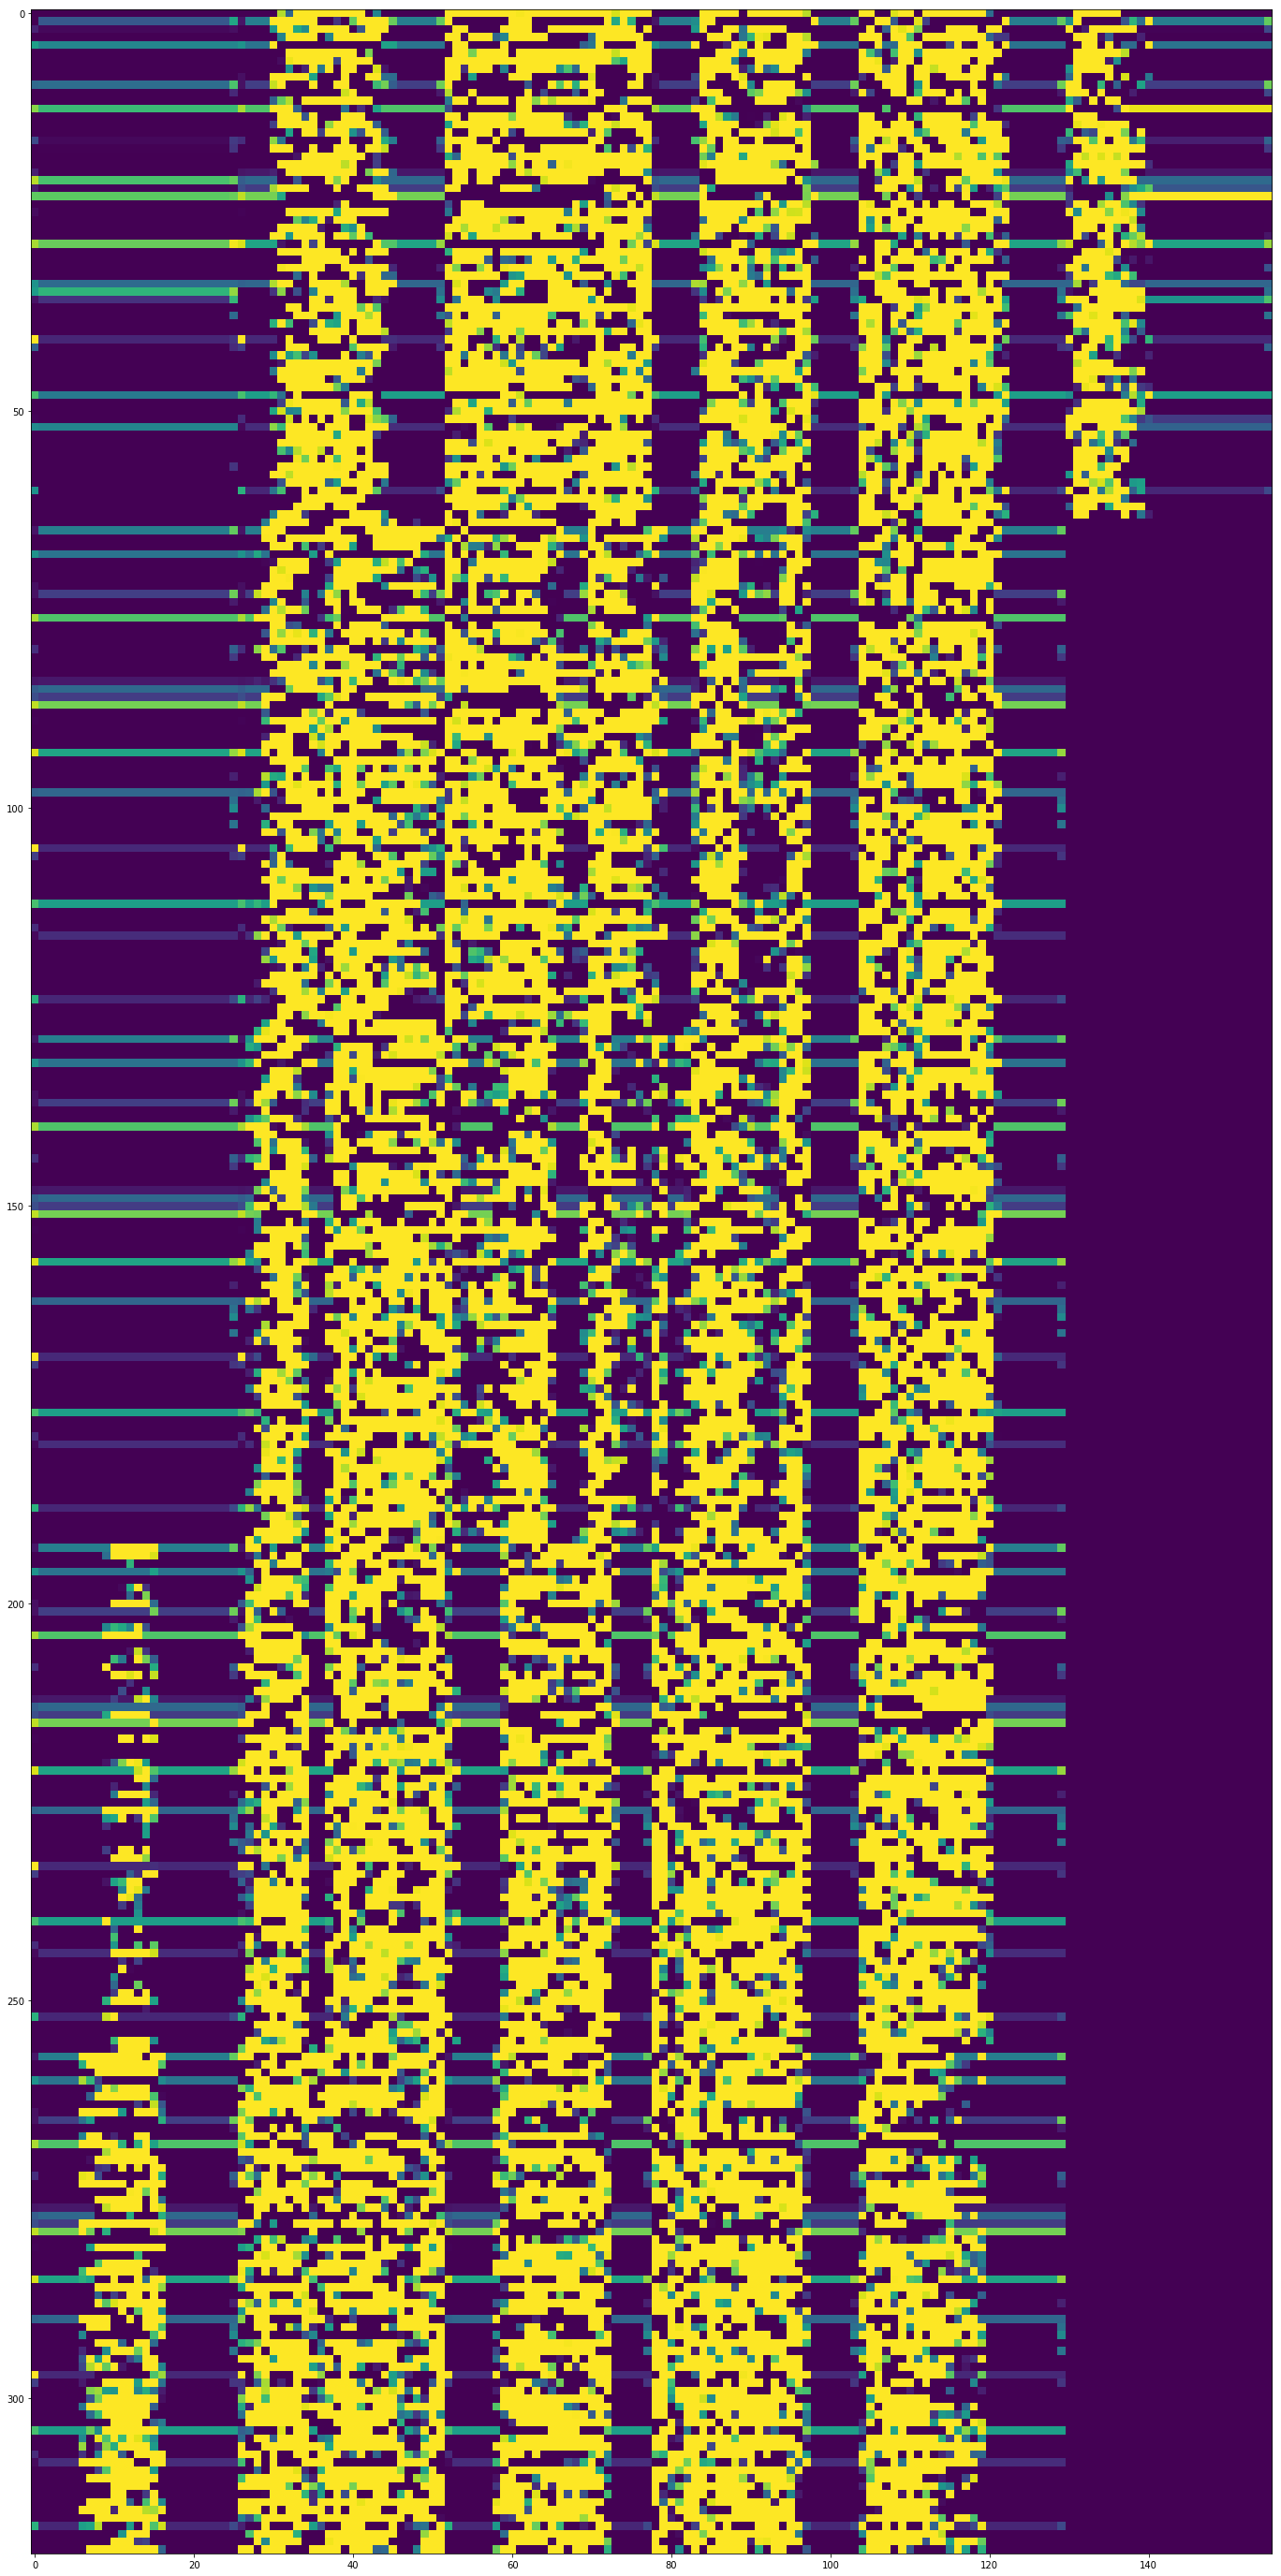

dropout_2


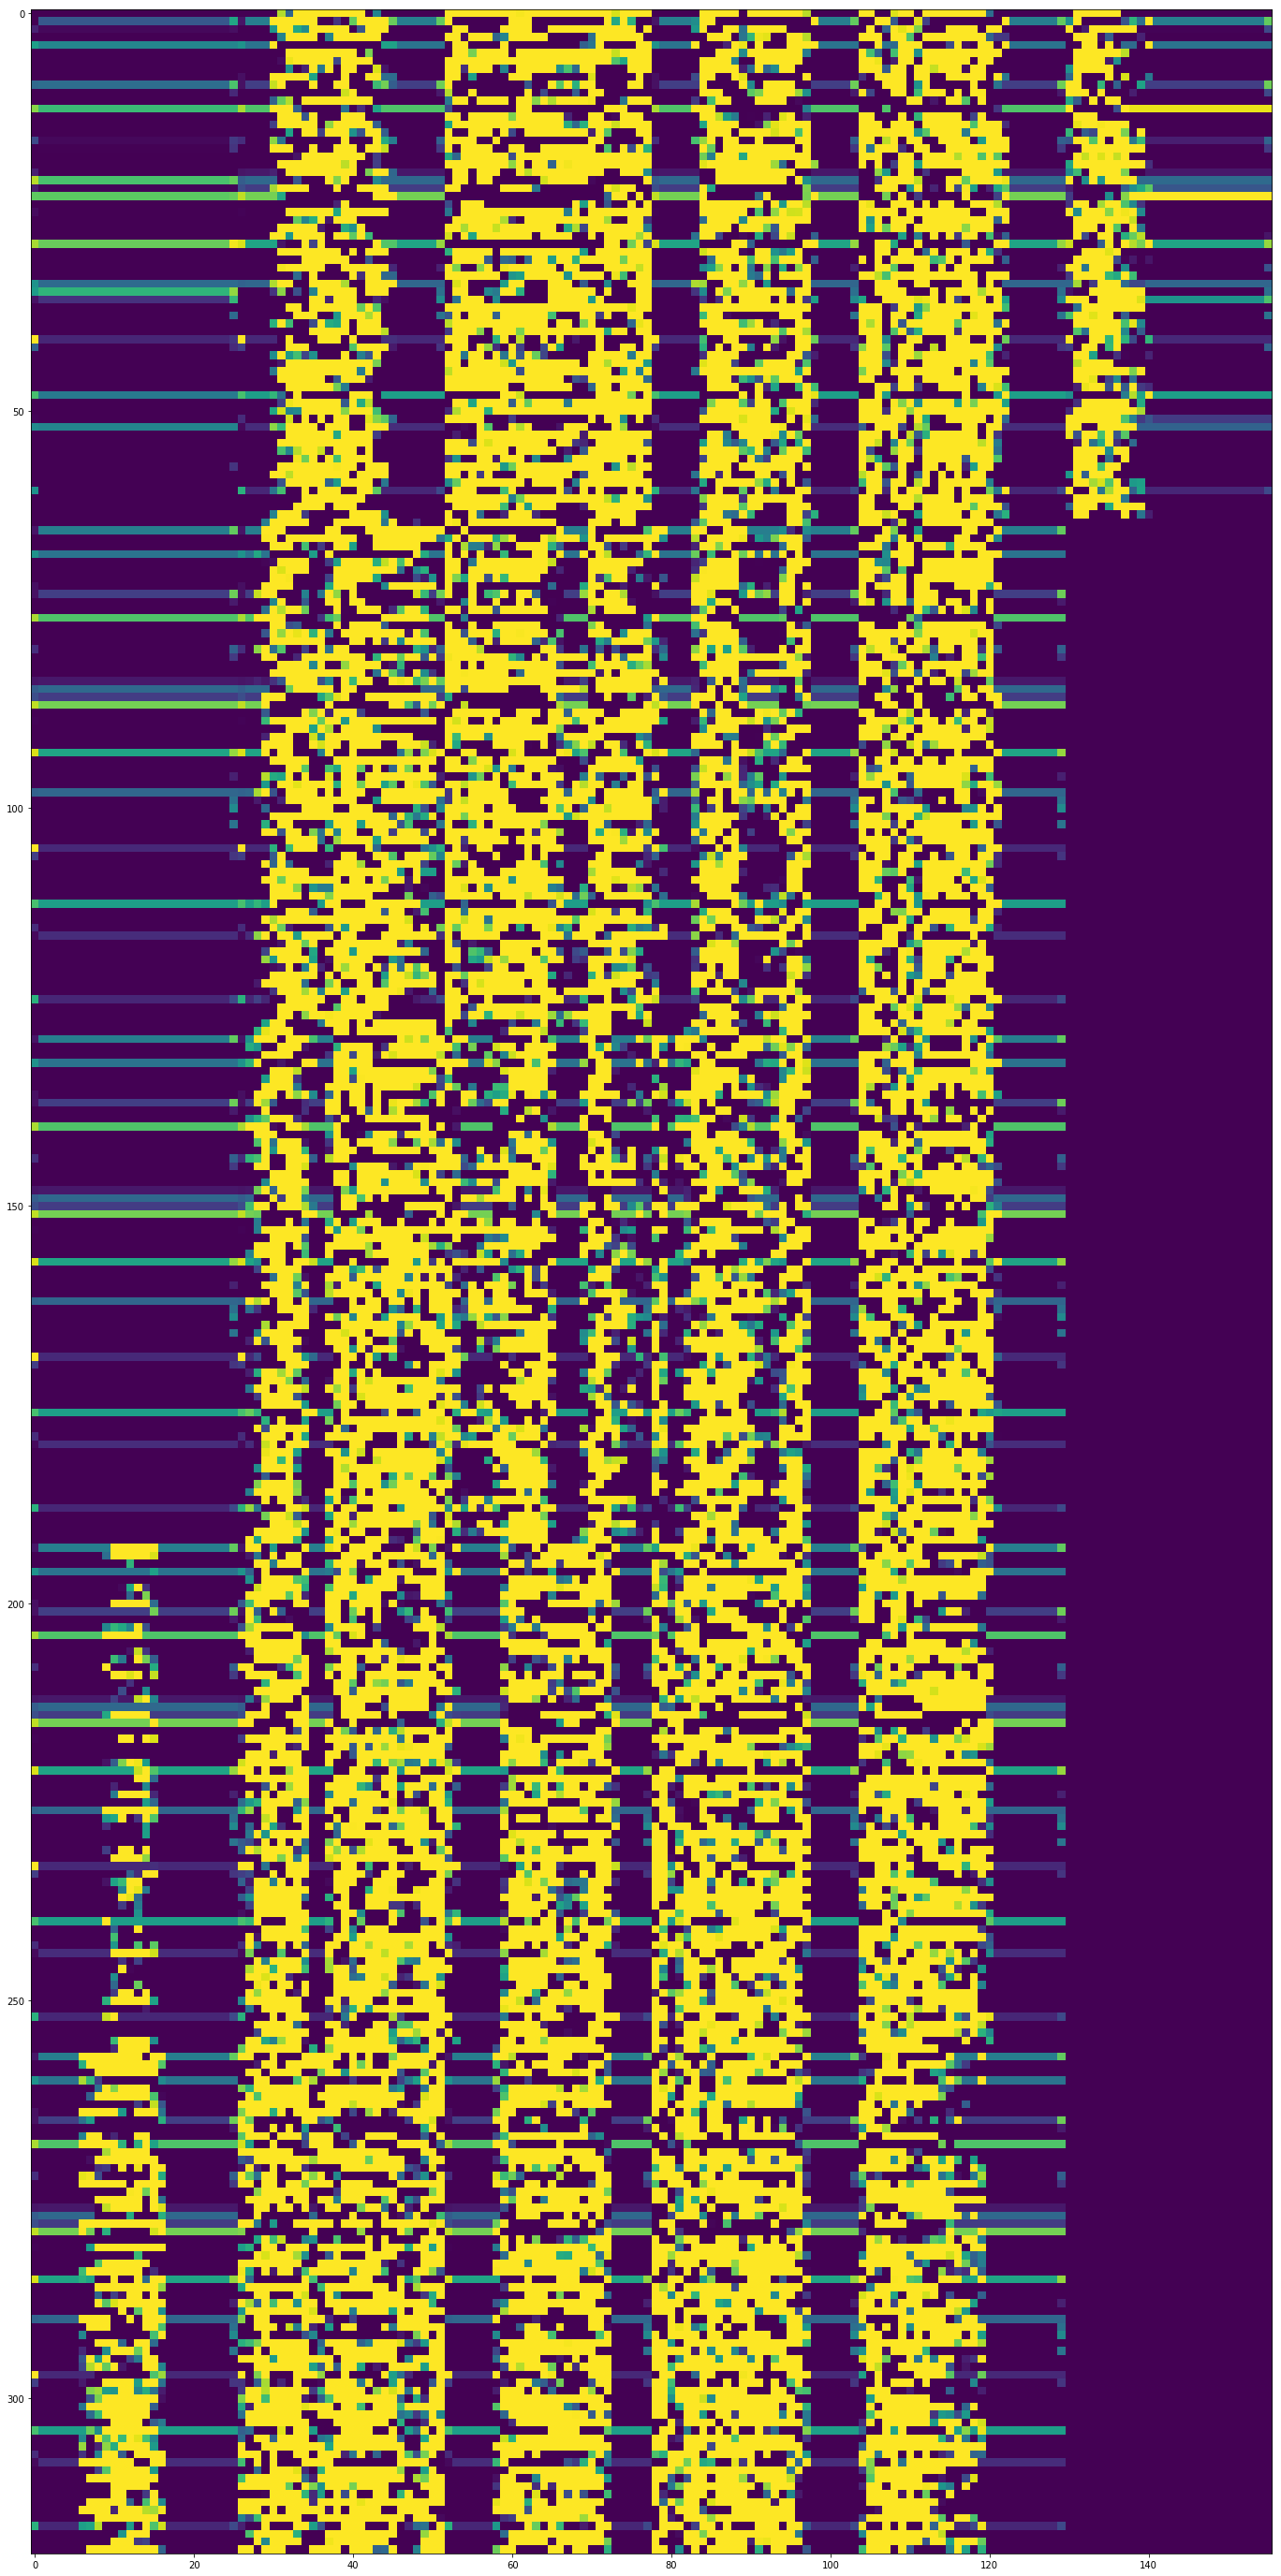

conv2d_4


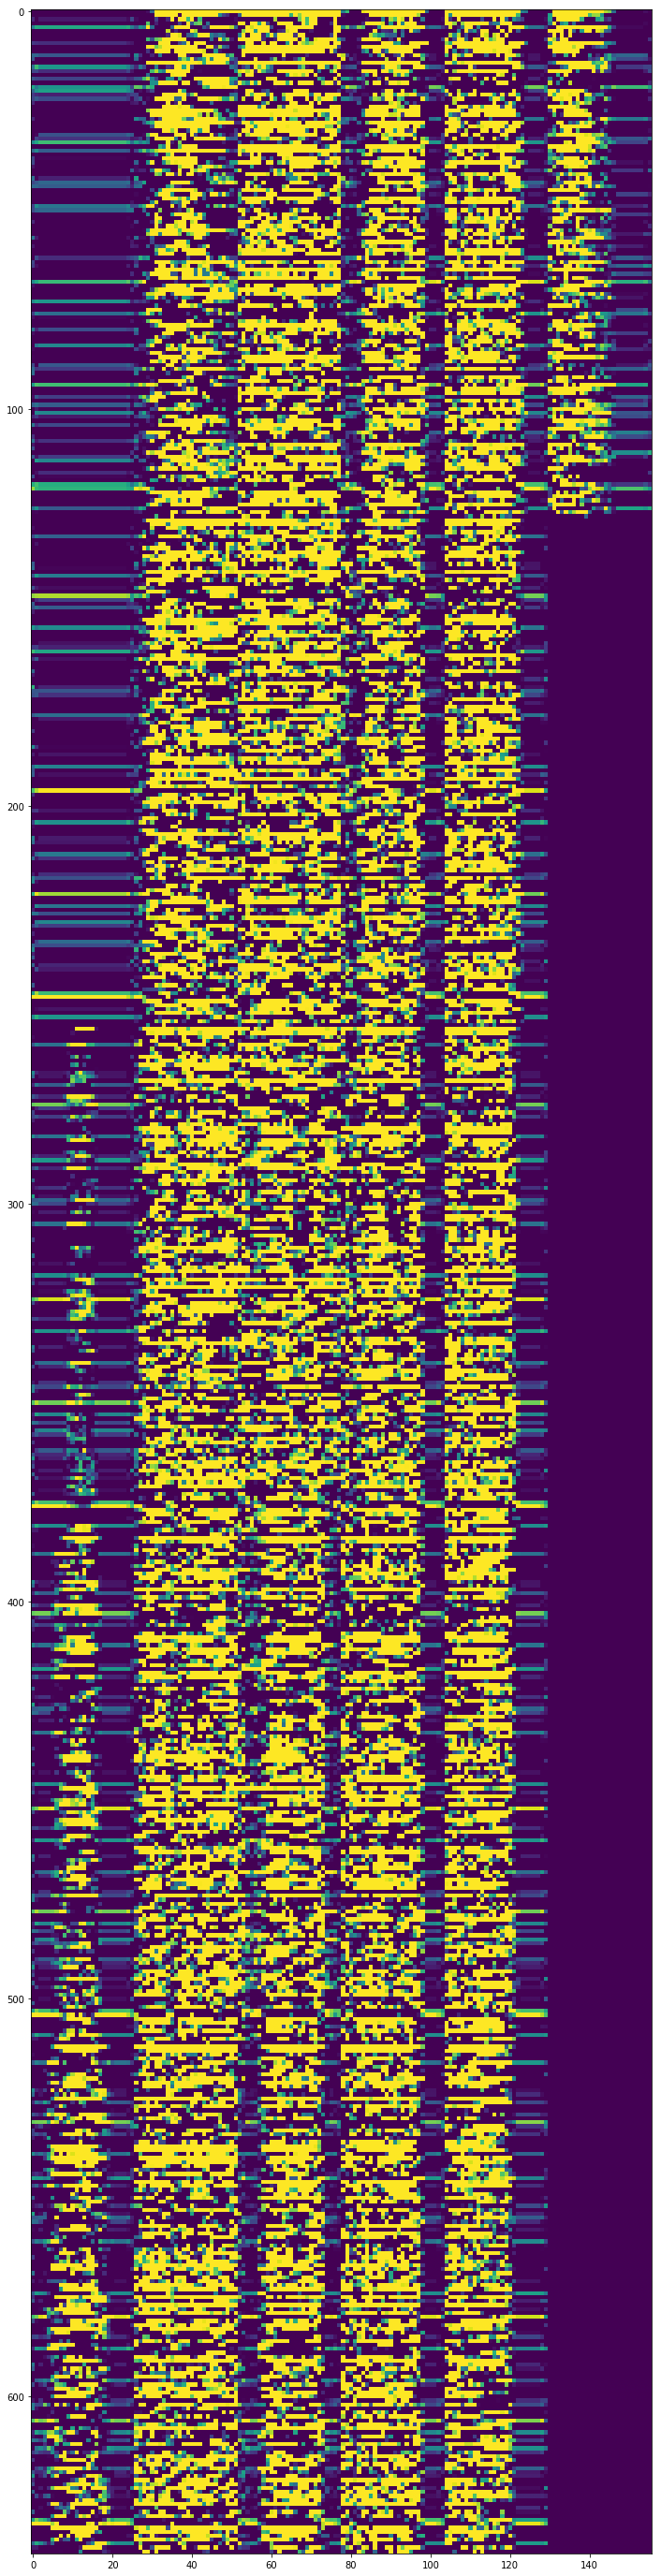

activation_4


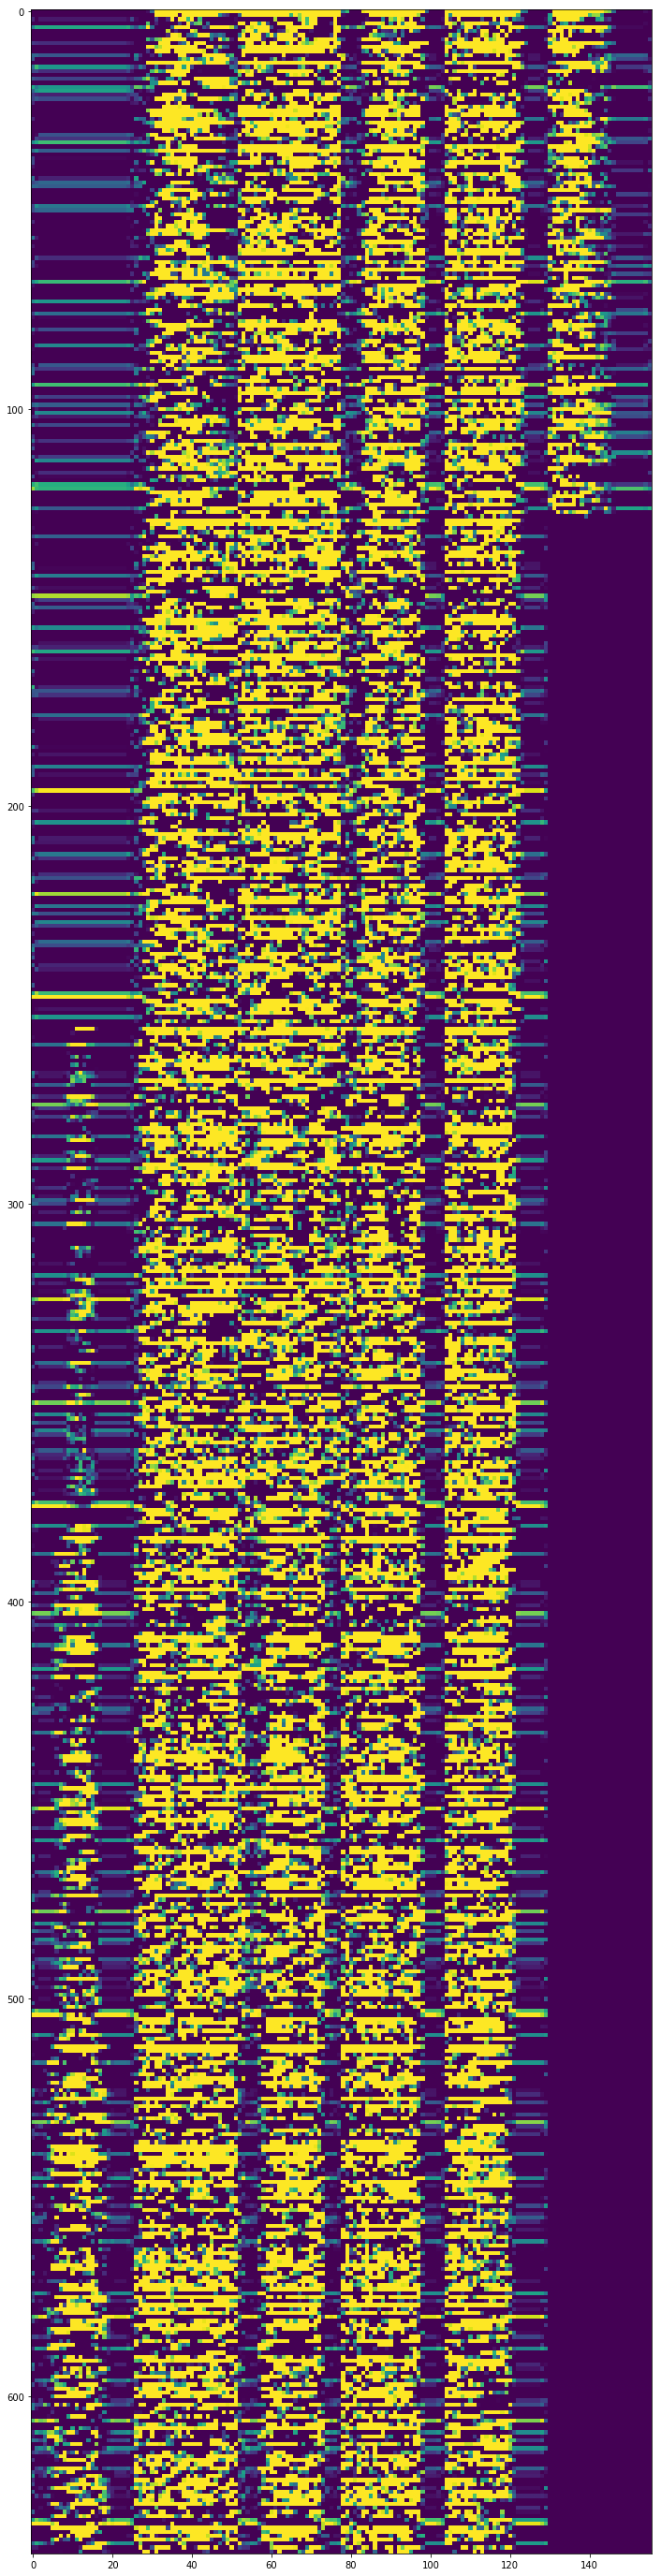

batch_normalization_4


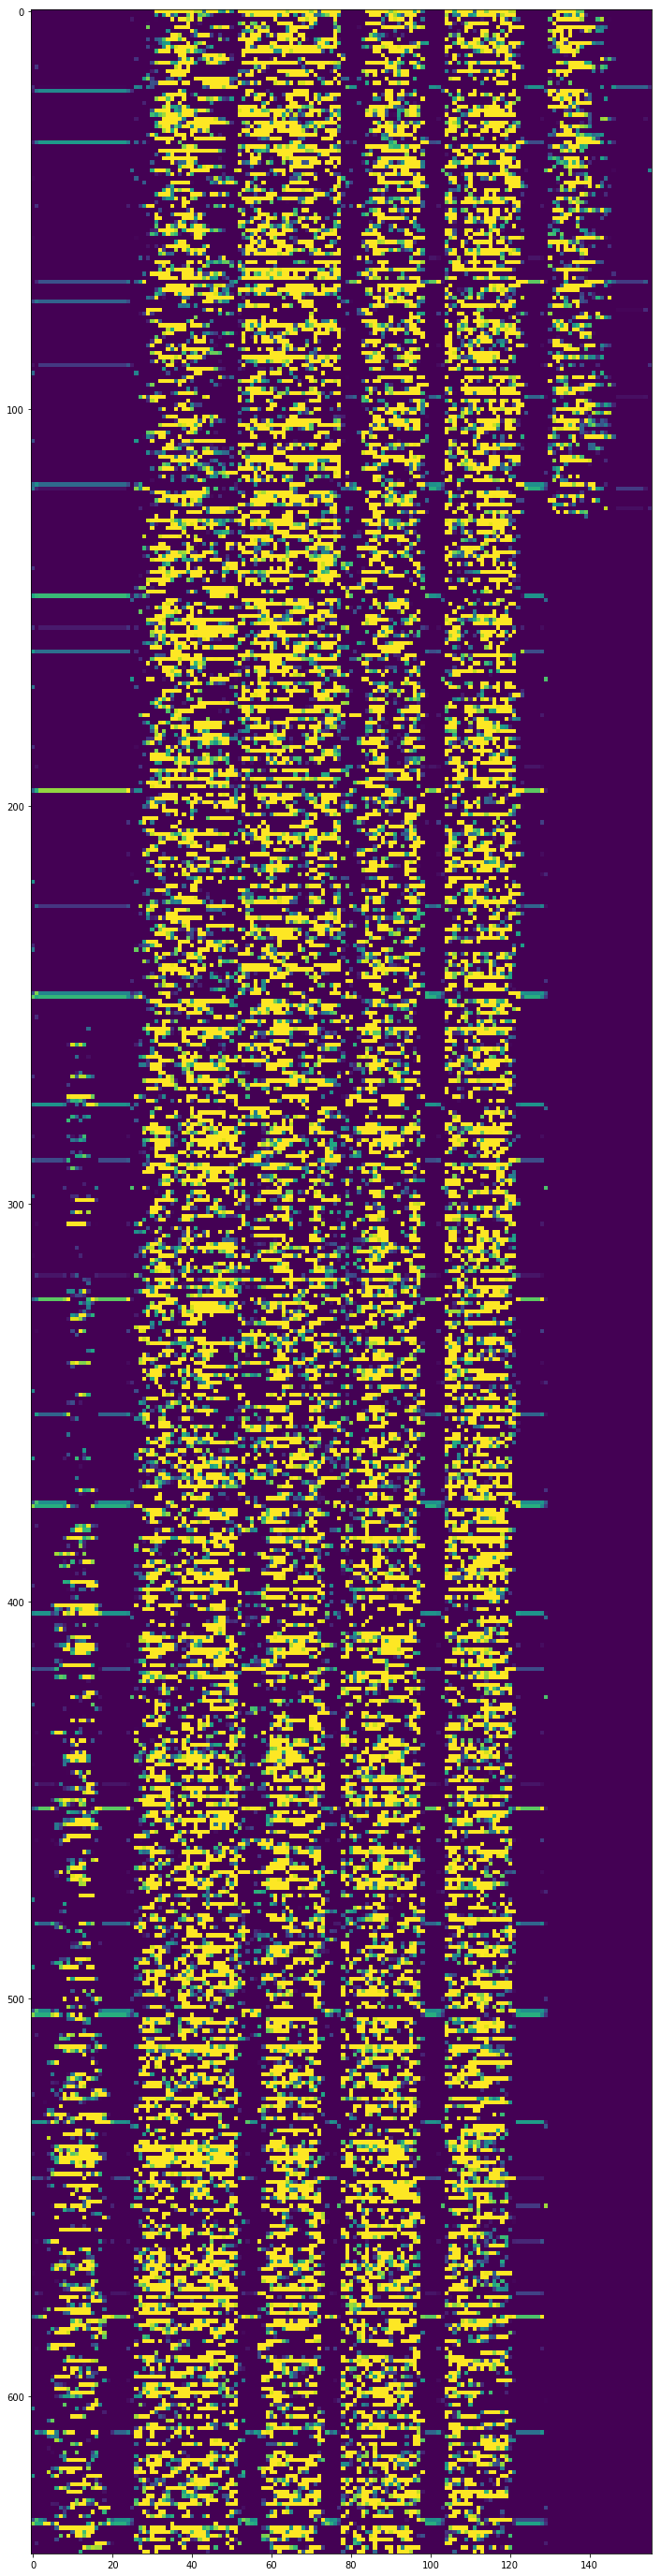

conv2d_5


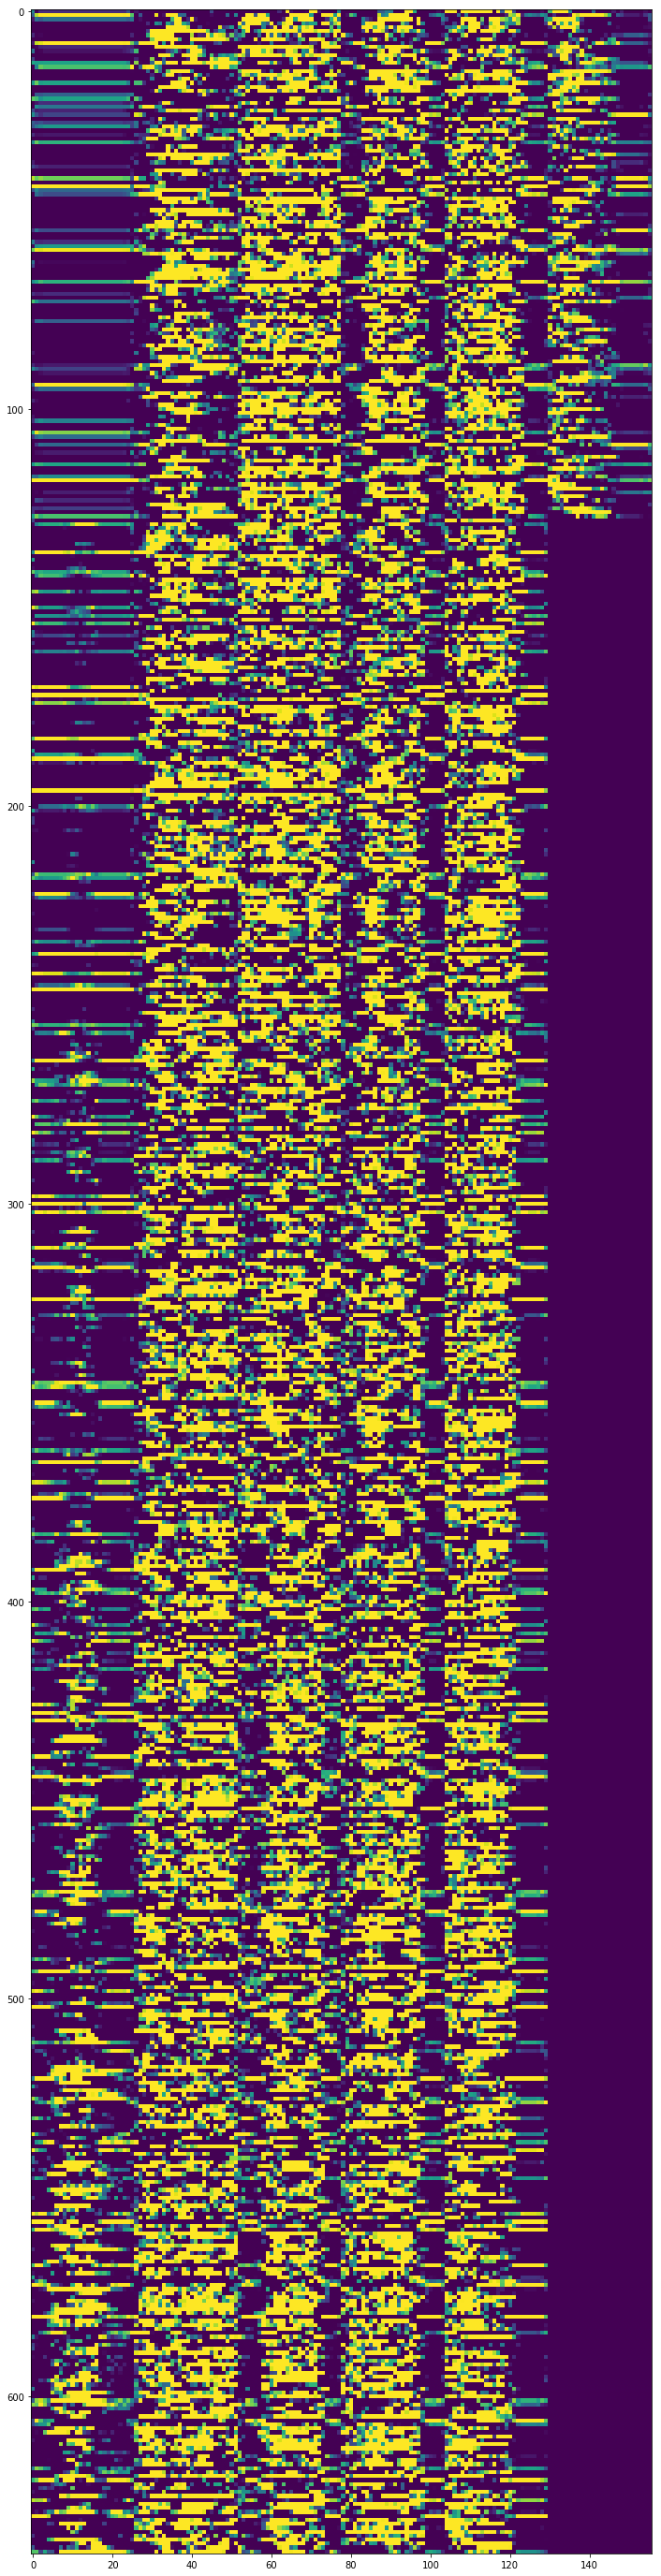

activation_5


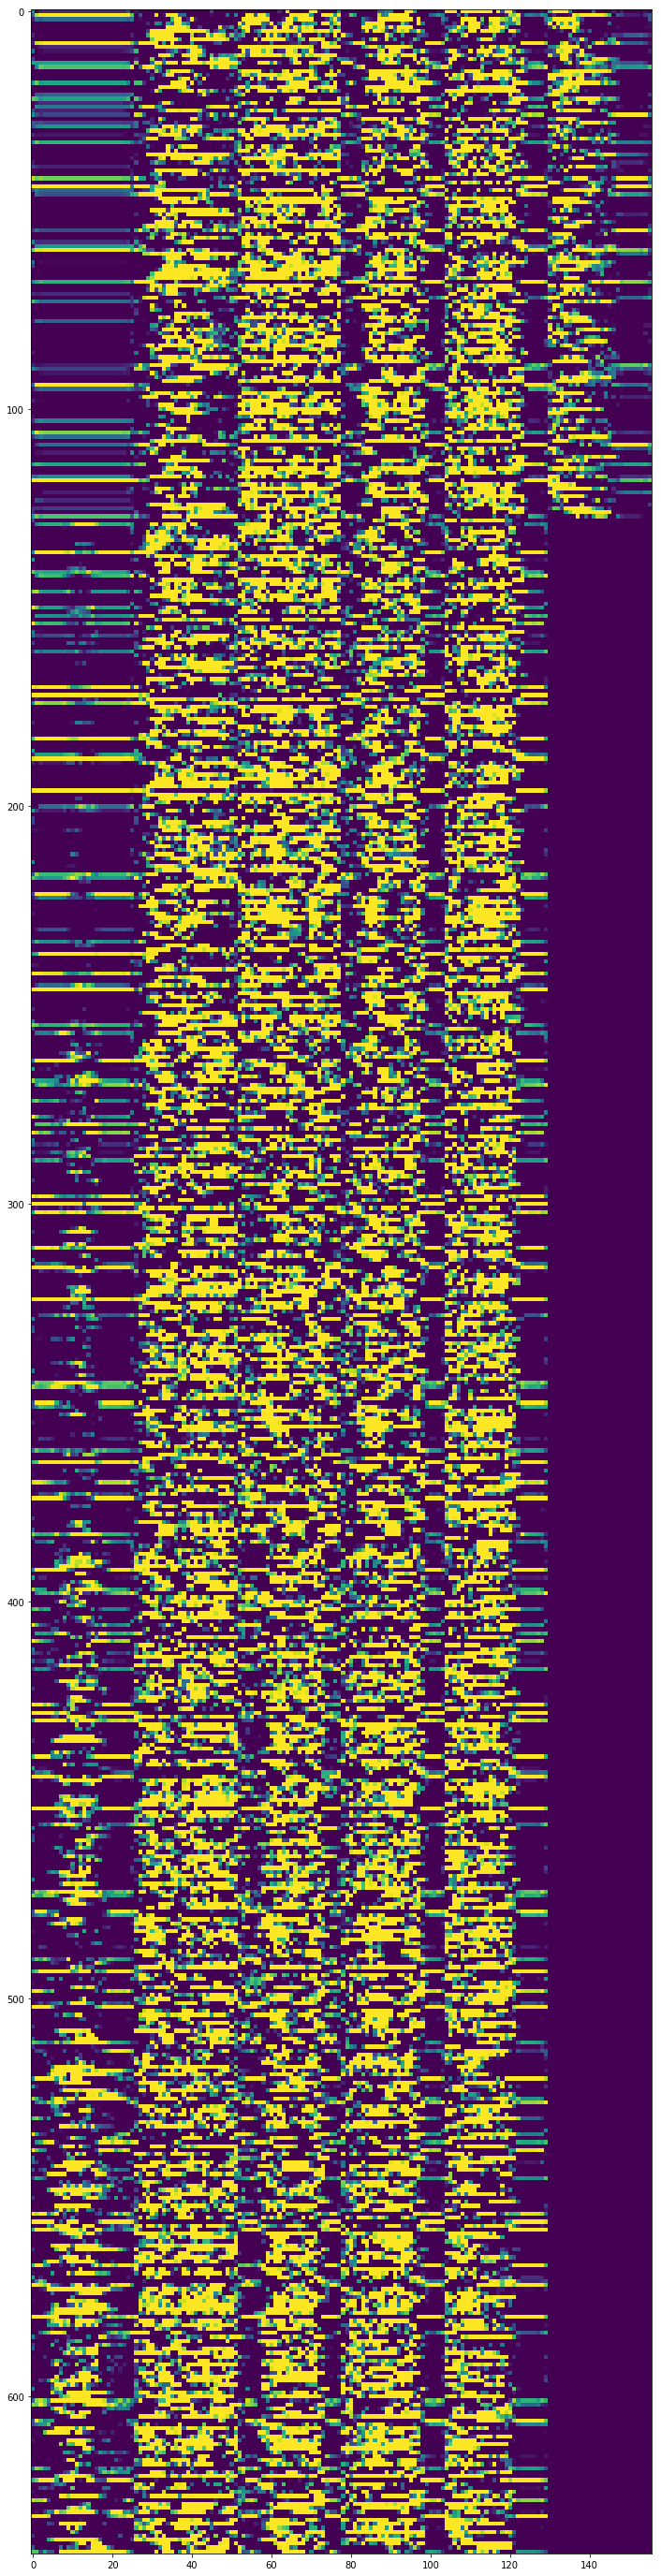

batch_normalization_5


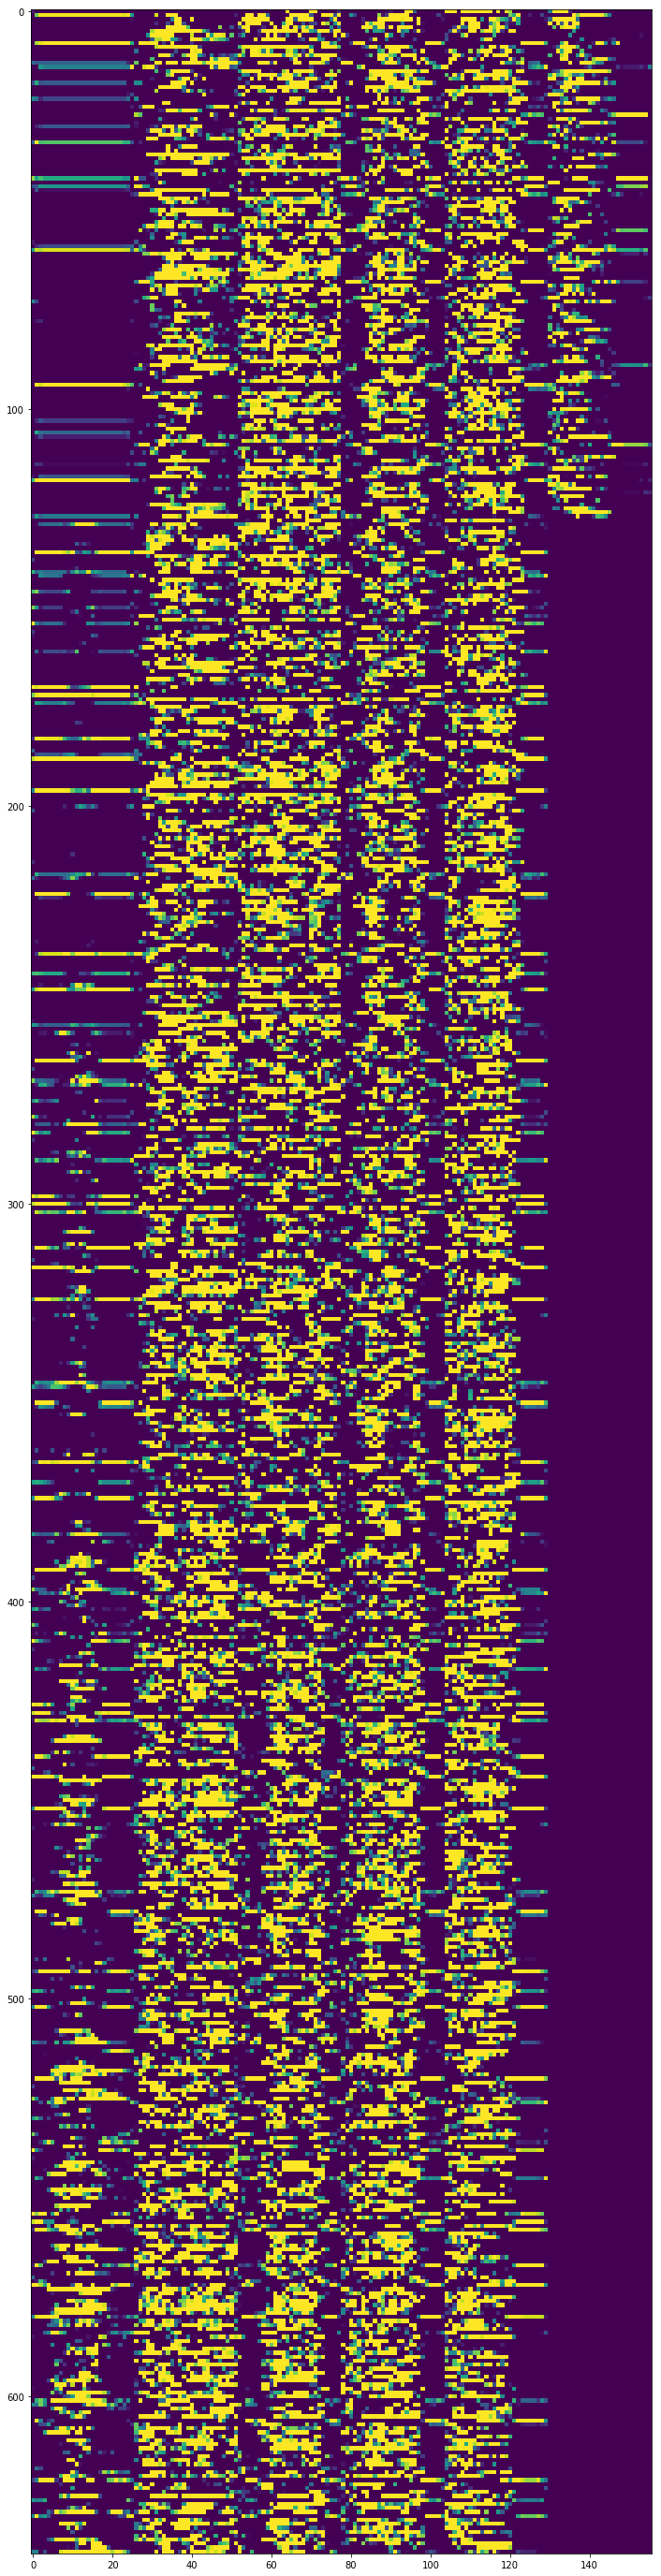

max_pooling2d_3


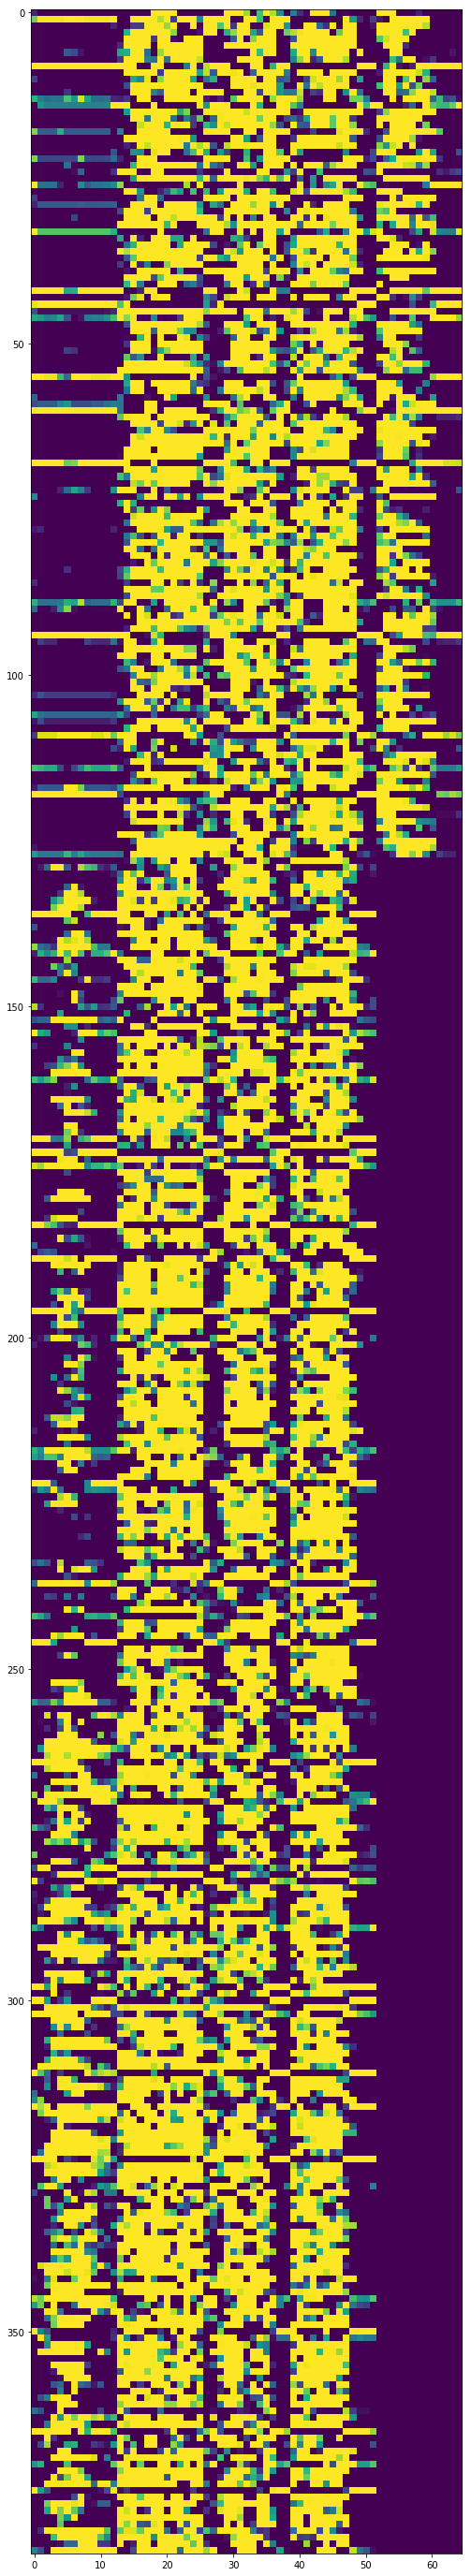

dropout_3


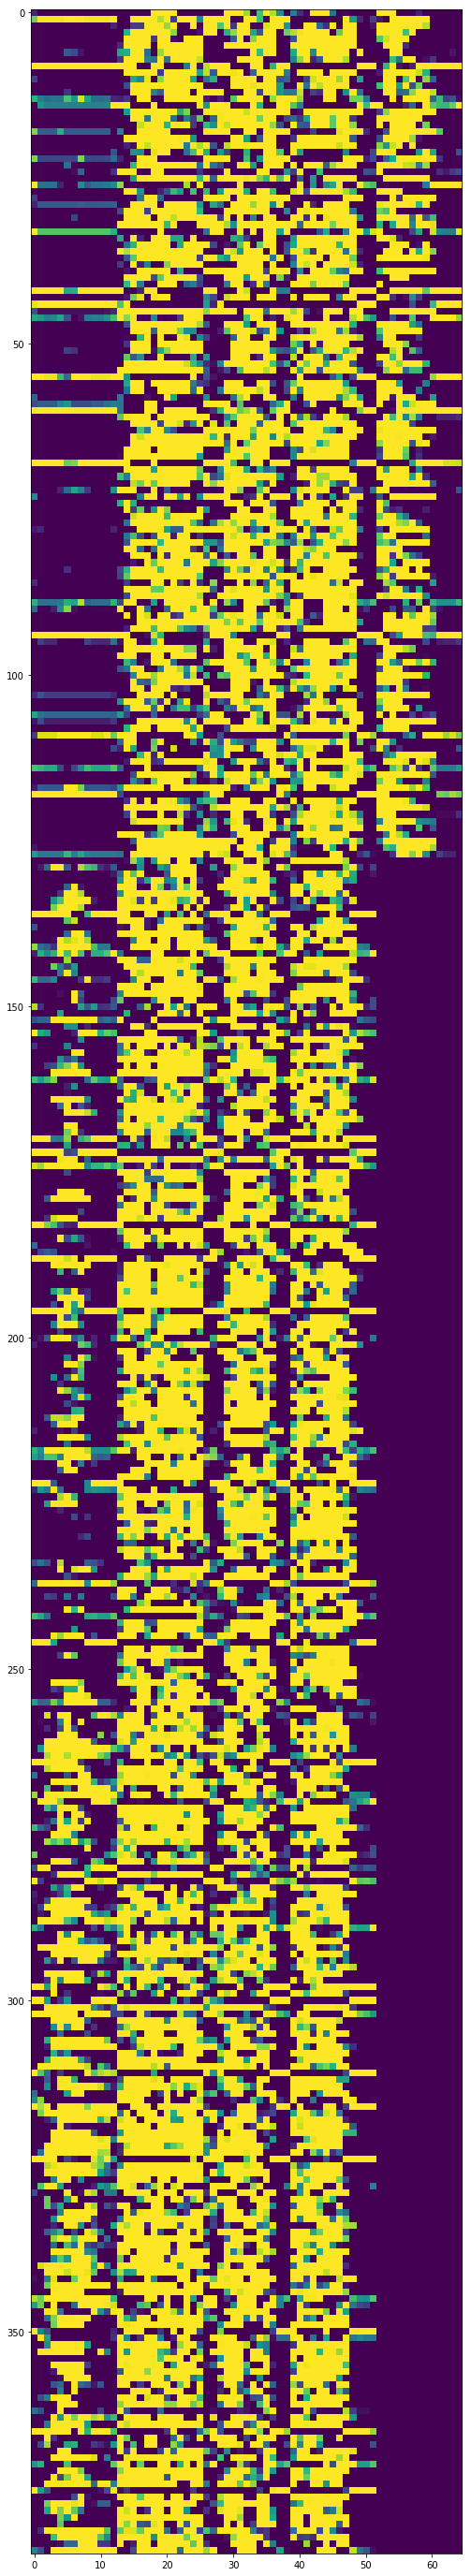

conv2d_6


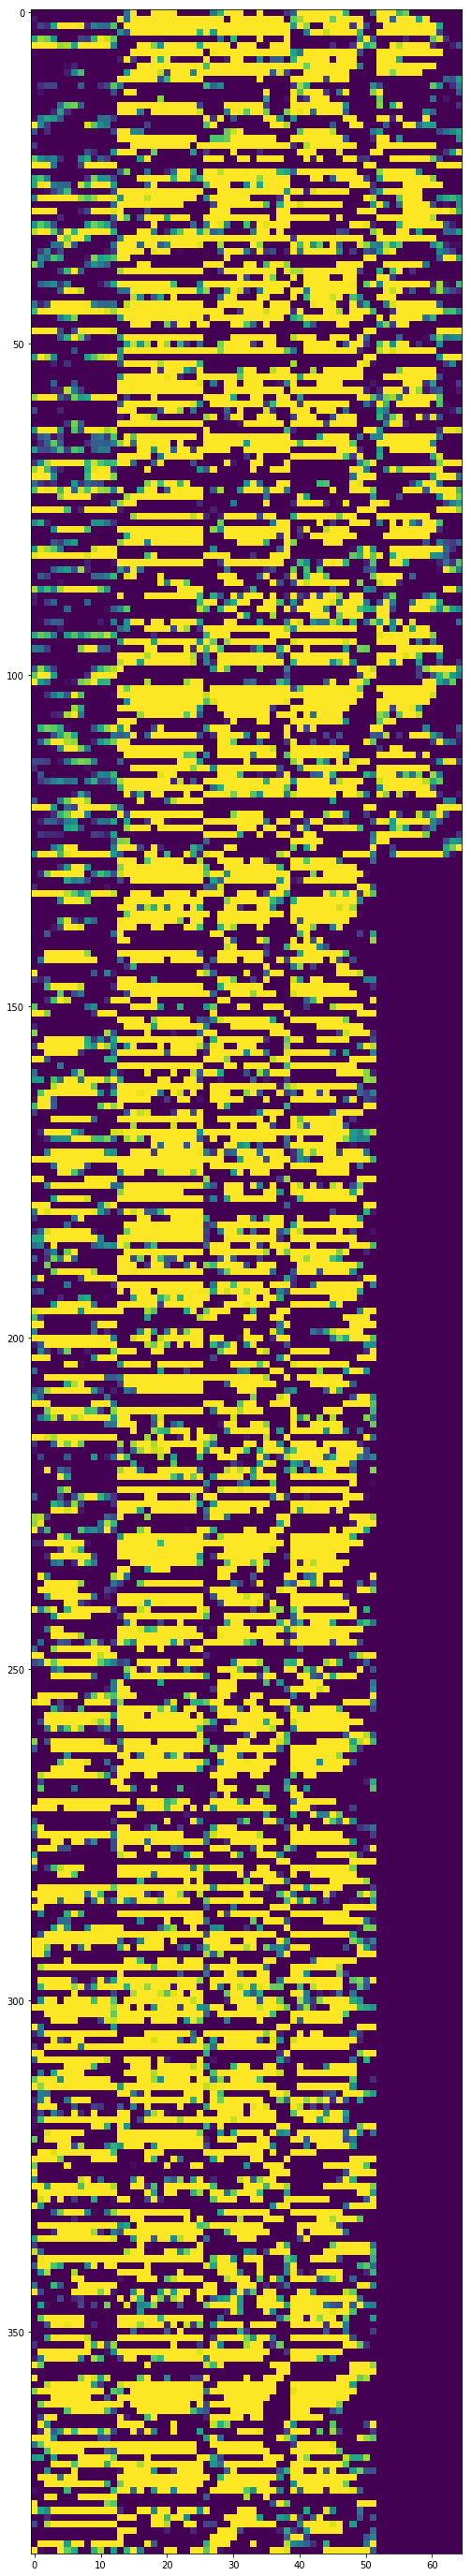

activation_6


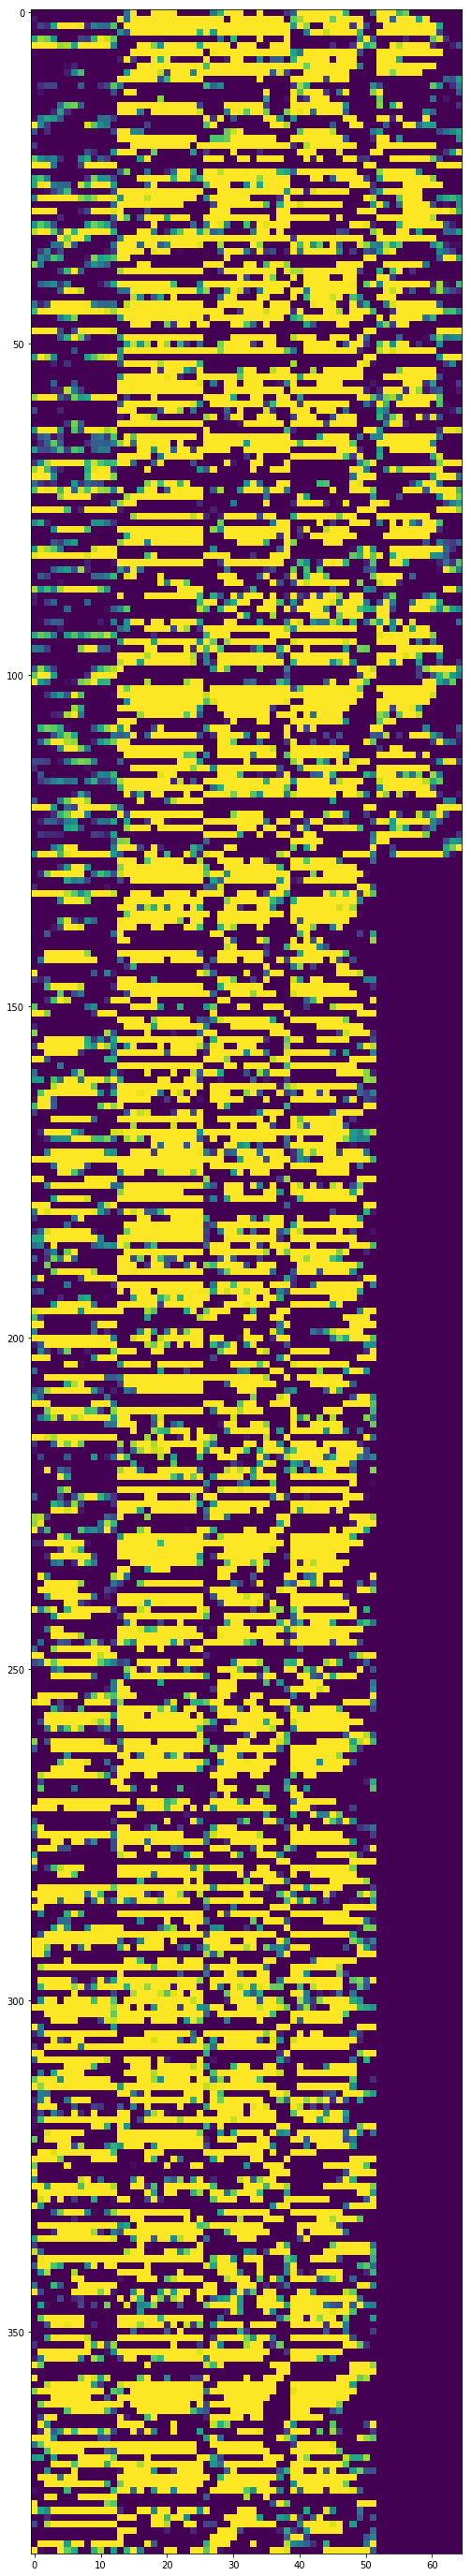

batch_normalization_6


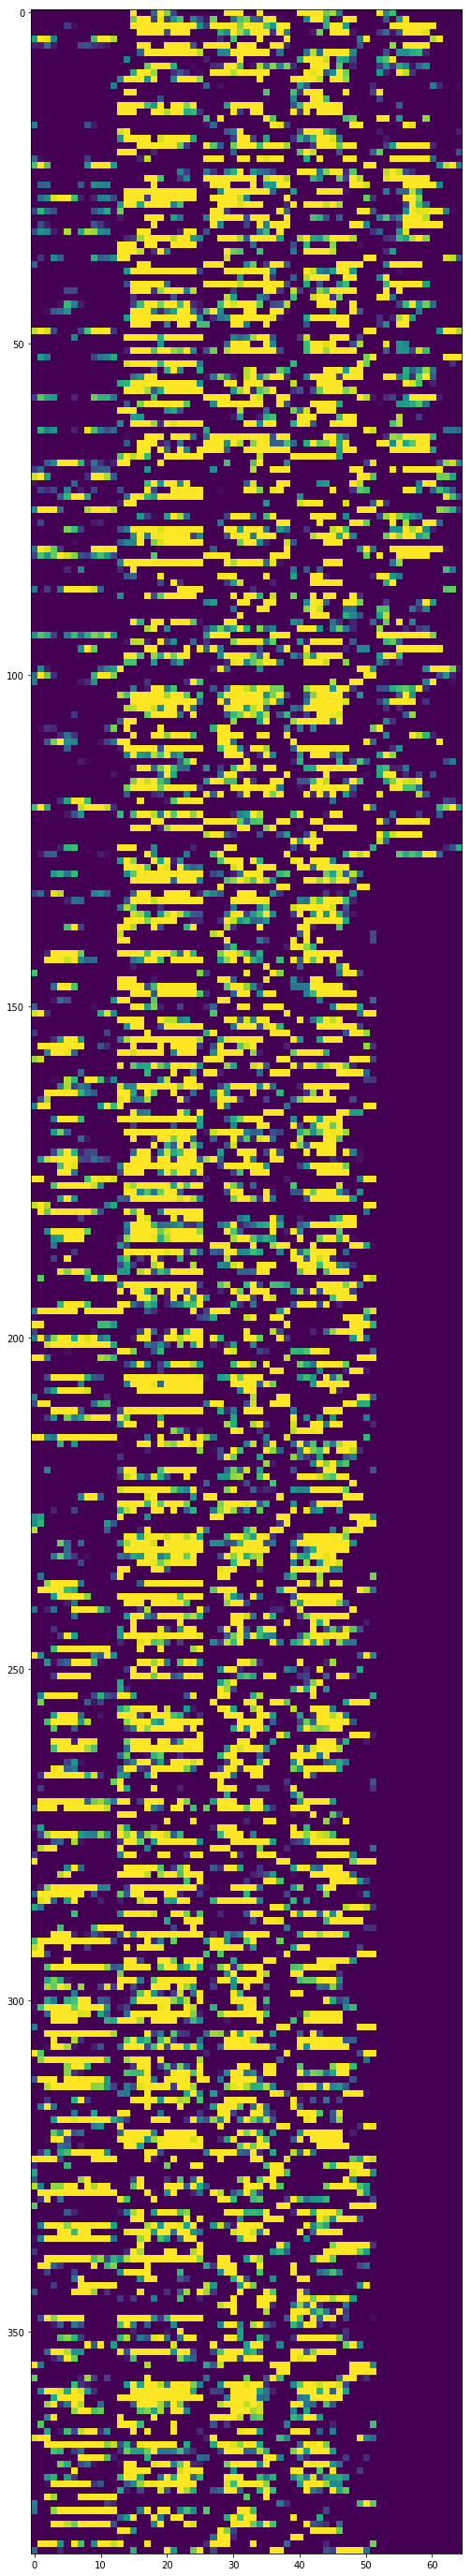

conv2d_7


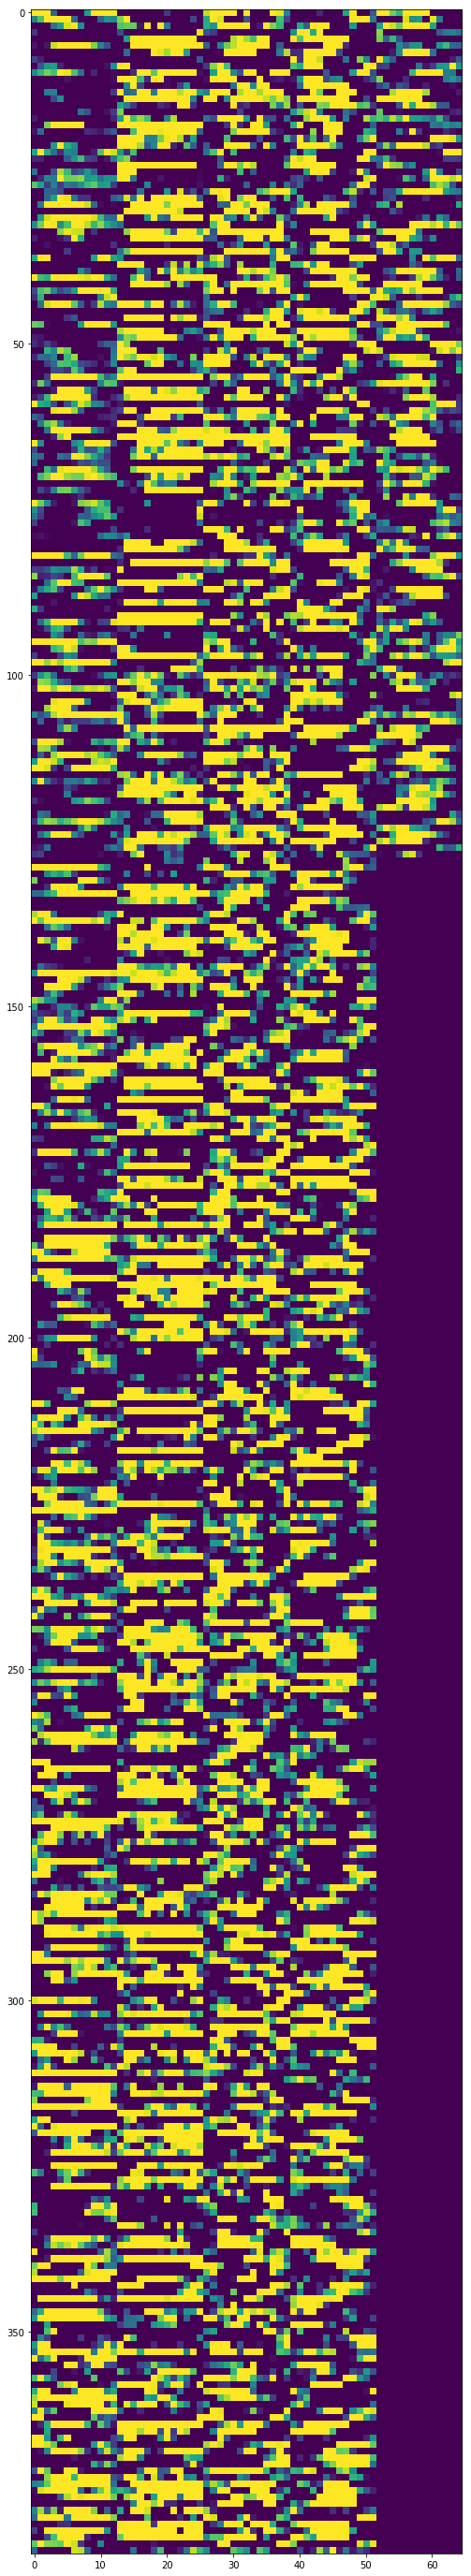

activation_7


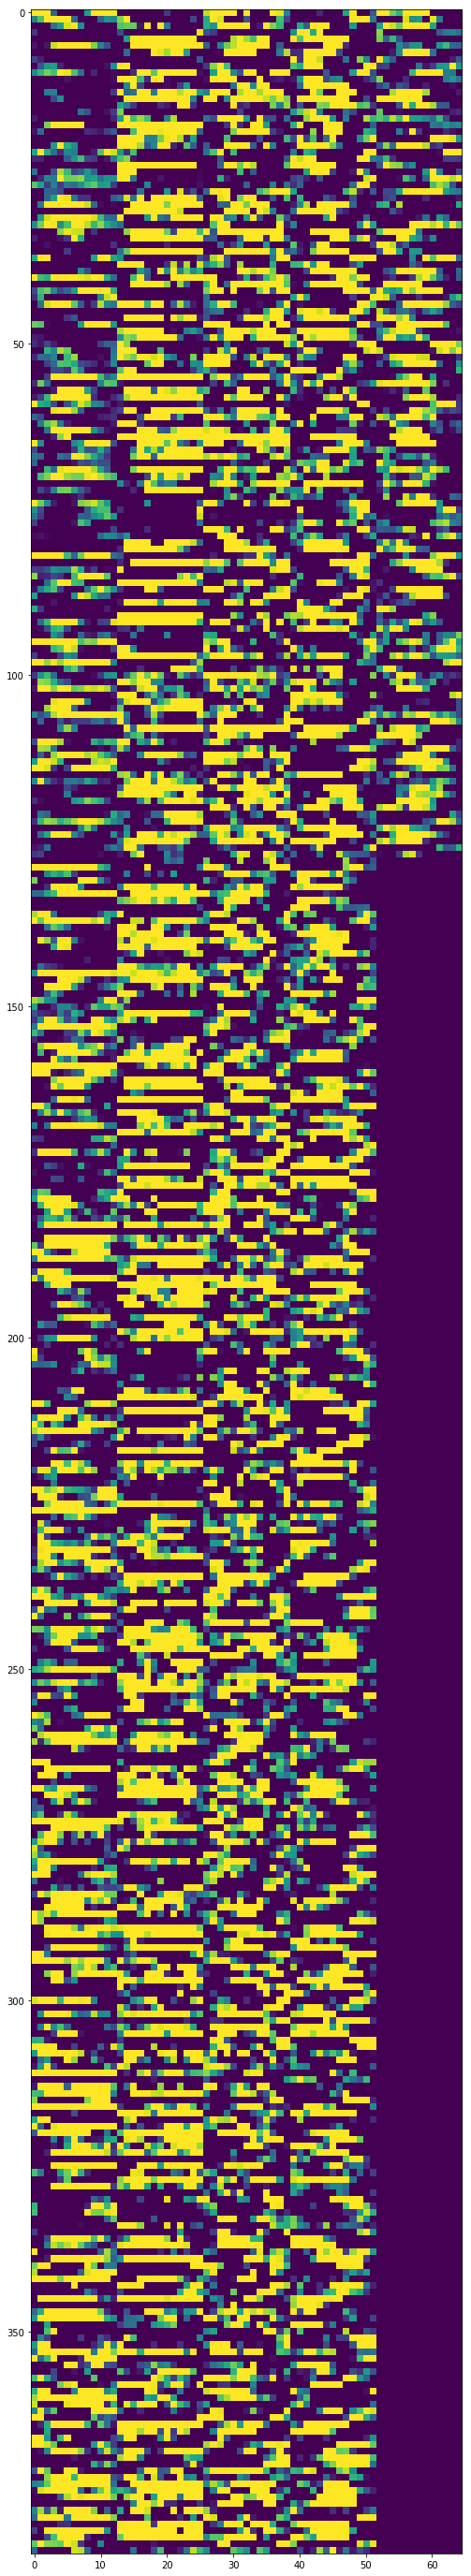

batch_normalization_7


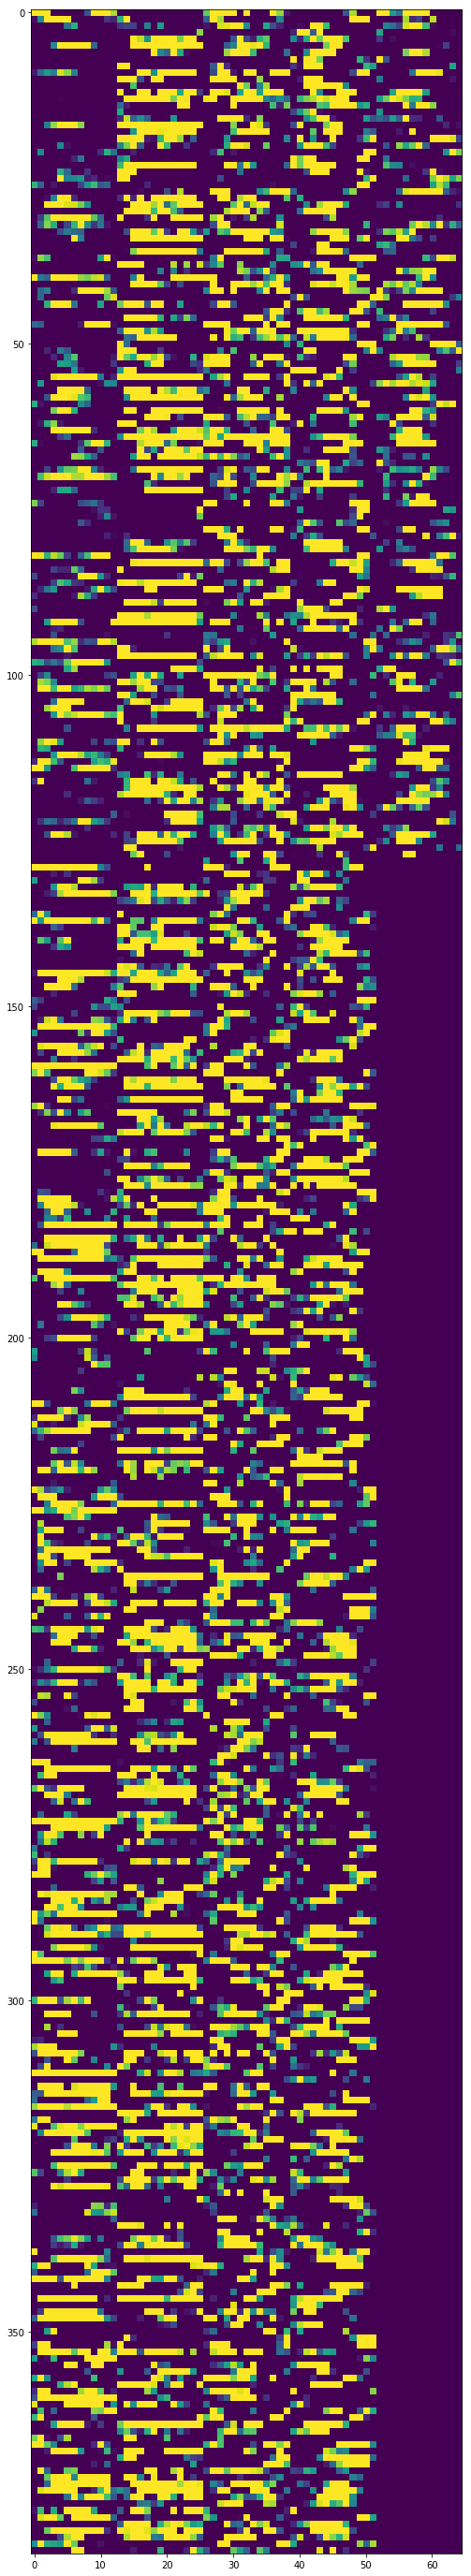

max_pooling2d_4


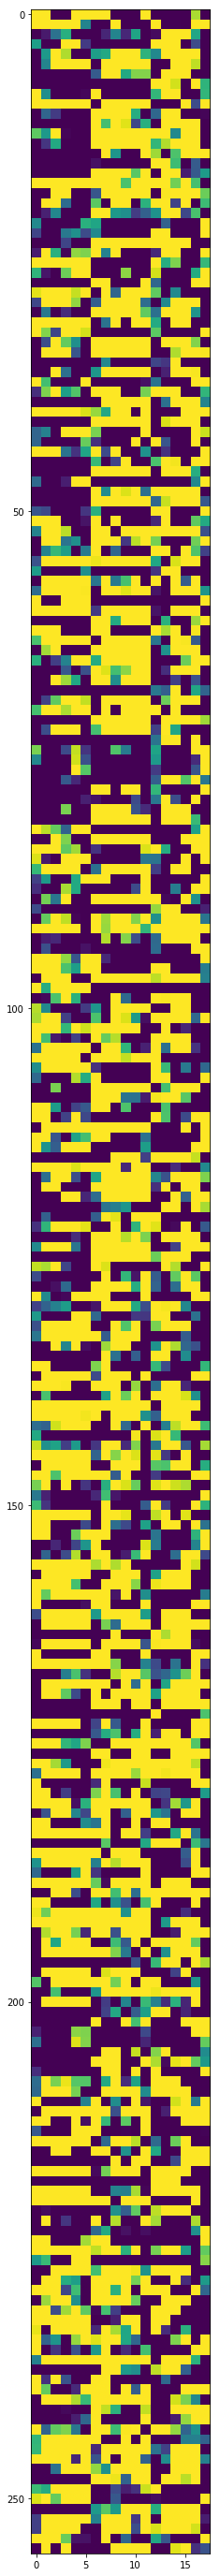

dropout_4


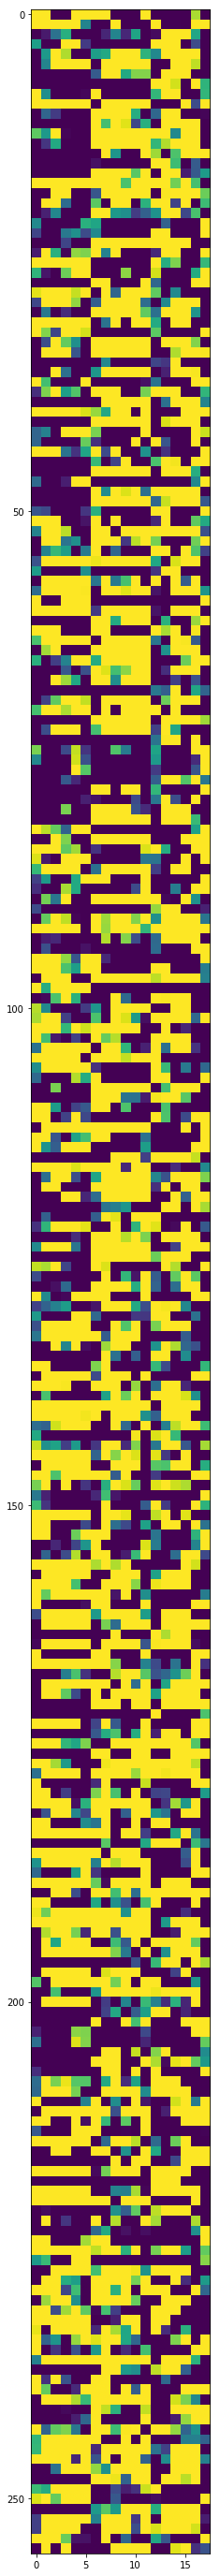

In [6]:
def get_model_layers_output_combined_image(model,model_input,training_flag=False):
    for layer_idx in range(len(model.layers)):
        kernels_output = get_kernels_output(model,layer_idx,model_input,False)
        combined_outputs_image = combine_output_images(kernels_output)
        if combined_outputs_image is not None:
            print(model.layers[layer_idx].name)
            plt.figure(figsize=(50,50))
            plt.imshow(combined_outputs_image.T,vmin=0.0,vmax =1.0,)
            plt.show()
get_model_layers_output_combined_image(model,image,False)            

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 160, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 160, 160, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 53, 53, 64)        0         
__________

In [9]:
import random
data = []
labels = []

print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)


for imagePath in imagePaths:
    img1 = cv2.imread(imagePath,1)
    img1 = cv2.resize(img1,(160,160))
    hsv = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)
    low = np.array([0,40,30])
    high = np.array([43,255,254])
    image_mask = cv2.inRange(hsv, low, high)
    output = cv2.bitwise_and(img1, img1, mask = image_mask)
    L1 = cv2.Canny(output,50,280,L2gradient=False)
    image = img_to_array(L1)
    data.append(image)
 
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

[INFO] loading images...


In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [13]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.4, random_state=32)

In [14]:
final_loss, final_acc = model.evaluate(testX, testY, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0575, final accuracy: 0.9778
